In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold

pd.set_option('display.max_columns', None)

### `Loading Dataset` 

In [2]:
path = '/Users/kanishkbhagat/DS/Semiconductors/India_Semiconductor_Distributor_v3_10000.xlsx'

Product_Master = pd.read_excel(path, sheet_name = 'Product_Master')
Inventory_Lot_Master = pd.read_excel(path, sheet_name = 'Inventory_Lot_Master')
Customer_Master = pd.read_excel(path, sheet_name = 'Customer_Master')
Customer_Forecast = pd.read_excel(path, sheet_name = 'Customer_Forecast')
Sales_Order = pd.read_excel(path, sheet_name = 'Sales_Order')
Purchase_Order = pd.read_excel(path, sheet_name = 'Purchase_Order')

In [3]:
Product_Master.head()

,Product_ID,Manufacturer,Manufacturer_Part_Number,Product_Category,Package_Type,Operating_Temp_Grade,Shelf_Life_Months,End_of_Life_Flag
0,SKU-100000,STMicroelectronics,STM32F760,Power IC,BGA,Industrial,84,Yes
1,SKU-100001,STMicroelectronics,STM32F898,Power IC,BGA,Industrial,84,No
2,SKU-100002,STMicroelectronics,STM32F755,Power IC,BGA,Automotive,84,No
3,SKU-100003,NXP Semiconductors,STM32F737,Analog IC,BGA,Industrial,72,No
4,SKU-100004,Texas Instruments,STM32F757,MCU,LQFP,Industrial,72,No


In [4]:
Inventory_Lot_Master.head()

,Inventory_Lot_ID,Product_ID,Warehouse_City,Manufacturing_Date,Lot_Received_Date,Expiry_Date,Quantity_Received,Quantity_Available,Unit_Landed_Cost_INR,Lot_Status
0,LOT-50000,SKU-108803,Noida,2024-07-12,2024-08-01,2030-06-11,2899,2602,383.79,Blocked
1,LOT-50001,SKU-102347,Bengaluru,2024-01-15,2024-02-04,2030-12-09,5350,2027,499.99,Active
2,LOT-50002,SKU-107266,Hyderabad,2024-02-28,2024-03-19,2029-02-01,2471,47,439.90,Active
3,LOT-50003,SKU-104861,Chennai,2024-06-10,2024-06-30,2031-05-05,6371,5799,128.00,Active
4,LOT-50004,SKU-108733,Bengaluru,2024-05-14,2024-06-03,2030-04-13,6428,1017,72.11,Active


In [5]:
Customer_Master.head()

,Customer_ID,Customer_Name,Customer_Type,Industry_Segment,City,Credit_Terms_Days,Strategic_Customer_Flag
0,CUST-2000,Tata Autocomp,OEM,Consumer Electronics,Hyderabad,30,Yes
1,CUST-2001,Ather Energy,OEM,EV,Chennai,45,No
2,CUST-2002,Tata Autocomp,OEM,Consumer Electronics,Pune,60,No
3,CUST-2003,Dixon Technologies,EMS,Consumer Electronics,Bengaluru,30,No
4,CUST-2004,Ola Electric,OEM,Consumer Electronics,Bengaluru,45,No


In [6]:
Customer_Forecast.head()

,Forecast_ID,Customer_ID,Product_ID,Forecast_Quantity,Forecast_Start_Date,Forecast_End_Date,Forecast_Type,Forecast_Status
0,FC-8000,CUST-11505,SKU-101709,5664,2024-10-10,2025-04-08,PO-backed,Withdrawn
1,FC-8001,CUST-5717,SKU-101230,3672,2024-07-14,2025-01-10,Email,Active
2,FC-8002,CUST-9991,SKU-102009,4115,2024-10-06,2025-04-04,Email,Active
3,FC-8003,CUST-11688,SKU-103788,2864,2024-07-28,2025-01-24,Verbal,Active
4,FC-8004,CUST-6534,SKU-105500,2736,2024-10-04,2025-04-02,PO-backed,Active


In [7]:
Sales_Order.head()

,Sales_Order_ID,Order_Date,Customer_ID,Product_ID,Inventory_Lot_ID,Ordered_Quantity,Order_Type,Order_Status,Actual_Ship_Date,Cancellation_Reason,Last_Time_Buy_Date
0,SO-70000,2024-07-02,CUST-2587,SKU-103979,LOT-56722,1885,Forecast,Cancelled,NaT,Design change,2024-05-15
1,SO-70001,2024-01-07,CUST-7583,SKU-101619,LOT-54655,2663,Firm,Delivered,2025-01-15,NaN,2023-10-02
2,SO-70002,2023-04-25,CUST-3177,SKU-108803,LOT-51122,1539,Forecast,Delivered,2025-01-15,NaN,2023-01-21
3,SO-70003,2023-10-21,CUST-8151,SKU-100615,LOT-57153,1427,Forecast,Delivered,2025-01-15,NaN,2024-01-02
4,SO-70004,2023-06-13,CUST-5633,SKU-108088,LOT-50323,2550,Forecast,Delivered,2025-01-15,NaN,2022-09-16


In [8]:
Purchase_Order.head()

,Purchase_Order_ID,Supplier_Name,Product_ID,PO_Date,PO_Quantity,MOQ,Expected_Receipt_Date,Actual_Receipt_Date,PO_Status
0,PO-40000,Mouser India,SKU-101203,2023-10-27,7701,8000,2023-12-11,2023-12-26,Closed
1,PO-40001,Mouser India,SKU-103447,2023-07-12,7093,8000,2023-08-26,2023-09-10,Closed
2,PO-40002,Digi-Key India,SKU-108845,2024-02-01,8861,8000,2024-03-17,2024-04-01,Closed
3,PO-40003,Mouser India,SKU-100749,2023-12-19,8524,5000,2024-02-02,2024-02-17,Closed
4,PO-40004,Arrow Electronics India,SKU-100620,2024-09-02,4072,3000,2024-10-17,2024-11-01,Closed


In [9]:
Customer_Forecast

,Forecast_ID,Customer_ID,Product_ID,Forecast_Quantity,Forecast_Start_Date,Forecast_End_Date,Forecast_Type,Forecast_Status
0,FC-8000,CUST-11505,SKU-101709,5664,2024-10-10,2025-04-08,PO-backed,Withdrawn
1,FC-8001,CUST-5717,SKU-101230,3672,2024-07-14,2025-01-10,Email,Active
2,FC-8002,CUST-9991,SKU-102009,4115,2024-10-06,2025-04-04,Email,Active
3,FC-8003,CUST-11688,SKU-103788,2864,2024-07-28,2025-01-24,Verbal,Active
4,FC-8004,CUST-6534,SKU-105500,2736,2024-10-04,2025-04-02,PO-backed,Active
...,...,...,...,...,...,...,...,...
9995,FC-17995,CUST-7036,SKU-105871,4505,2024-07-27,2025-01-23,Email,Active
9996,FC-17996,CUST-6323,SKU-108282,2045,2024-08-22,2025-02-18,Verbal,Withdrawn
9997,FC-17997,CUST-5043,SKU-105648,2100,2024-08-20,2025-02-16,Email,Active
9998,FC-17998,CUST-5589,SKU-104961,2323,2024-07-14,2025-01-10,Email,Active


---
# `Merging Tables`
---

In [10]:
Customer_table = Customer_Forecast.merge(Customer_Master, on = 'Customer_ID')

In [11]:
Product_table = Product_Master.merge(Inventory_Lot_Master, on = 'Product_ID')\
                .merge(Sales_Order, on = 'Product_ID')\
                .merge(Purchase_Order, on = 'Product_ID')

In [12]:
df = Product_table.merge(Customer_table, on = 'Product_ID')

In [13]:
df_meta = {'Entity': ['Manufacturer', 'Supplier_Name', 'Customer_Name'],
           
           'ID': ['Product_ID', 'Inventory_Lot_ID', 'Sales_Order_ID', 'Customer_ID',
                  'Purchase_Order_ID', 'Forecast_ID', 'Manufacturer_Part_Number'],
           
           'Date': ['Manufacturing_Date', 'Lot_Received_Date', 'Expiry_Date', 'Order Date',
                    'Actual_Ship_Date', 'Last_Time_Buy_Date', 'PO_Date',
                    'Expected_Receipt_Date', 'Actual_Receipt_Date', 'Forecast_Start_Date',
                    'Forecast_End_Date'],
           
           'Location': ['Warehouse_City', 'City'],
           
           'Order_Info': ['Order_Status', 'Forecast_Type', 'Forecast_Status',
                          'Order_Type'],
           
           'Amount': ['Unit_Landed_Cost_INR'],
           
           'Stock_Info':  ['Product_Category', 'Package_Type', 'Operating_Temp_Grade'],
           
           'Customer_Info': ['Customer_Type', 'Strategic_Customer_Flag',
                             'Industry Segment'],
           
           'Quantity': ['Quantity_Received', 'Quantity_Available', 'Ordered_Quantity',
                        'PO_Quantity', 'MOQ', 'Forecast_Quantity'],
           
           'Days': ['Shelf_Life_Month', 'Credit_Term_Days'],
          
           'Dead Stock': ['End_of_Life_Flag', 'Lot_Status', 'Cancellation_Reason'],
           
           'Not_Needed': ['PO_Status']}

df_meta = pd.DataFrame({k: pd.Series(v) for k, v in df_meta.items()}).fillna(' ').T

In [14]:
df_meta

,0,1,2,3,4,5,6,7,8,9,10
Entity,Manufacturer,Supplier_Name,Customer_Name,,,,,,,,
ID,Product_ID,Inventory_Lot_ID,Sales_Order_ID,Customer_ID,Purchase_Order_ID,Forecast_ID,Manufacturer_Part_Number,,,,
Date,Manufacturing_Date,Lot_Received_Date,Expiry_Date,Order Date,Actual_Ship_Date,Last_Time_Buy_Date,PO_Date,Expected_Receipt_Date,Actual_Receipt_Date,Forecast_Start_Date,Forecast_End_Date
Location,Warehouse_City,City,,,,,,,,,
Order_Info,Order_Status,Forecast_Type,Forecast_Status,Order_Type,,,,,,,
Amount,Unit_Landed_Cost_INR,,,,,,,,,,
Stock_Info,Product_Category,Package_Type,Operating_Temp_Grade,,,,,,,,
Customer_Info,Customer_Type,Strategic_Customer_Flag,Industry Segment,,,,,,,,
Quantity,Quantity_Received,Quantity_Available,Ordered_Quantity,PO_Quantity,MOQ,Forecast_Quantity,,,,,
Days,Shelf_Life_Month,Credit_Term_Days,,,,,,,,,


In [15]:
df_meta.to_csv('df_meta.csv')

In [16]:
df

,Product_ID,Manufacturer,Manufacturer_Part_Number,Product_Category,Package_Type,Operating_Temp_Grade,Shelf_Life_Months,End_of_Life_Flag,Inventory_Lot_ID_x,Warehouse_City,Manufacturing_Date,Lot_Received_Date,Expiry_Date,Quantity_Received,Quantity_Available,Unit_Landed_Cost_INR,Lot_Status,Sales_Order_ID,Order_Date,Customer_ID_x,Inventory_Lot_ID_y,Ordered_Quantity,Order_Type,Order_Status,Actual_Ship_Date,Cancellation_Reason,Last_Time_Buy_Date,Purchase_Order_ID,Supplier_Name,PO_Date,PO_Quantity,MOQ,Expected_Receipt_Date,Actual_Receipt_Date,PO_Status,Forecast_ID,Customer_ID_y,Forecast_Quantity,Forecast_Start_Date,Forecast_End_Date,Forecast_Type,Forecast_Status,Customer_Name,Customer_Type,Industry_Segment,City,Credit_Terms_Days,Strategic_Customer_Flag
0,SKU-100008,Texas Instruments,STM32F823,MCU,LQFP,Automotive,60,No,LOT-51260,Pune,2024-05-27,2024-06-16,2030-04-26,6391,2629,470.55,Active,SO-70828,2025-01-13,CUST-7274,LOT-58374,1533,Forecast,Delivered,2025-01-15,NaN,2023-07-01,PO-49036,Avnet India,2024-08-11,9456,3000,2024-09-25,2024-10-10,Closed,FC-16548,CUST-6677,3491,2024-07-11,2025-01-07,Email,Active,Ather Energy,OEM,Automotive,Chennai,30,No
1,SKU-100008,Texas Instruments,STM32F823,MCU,LQFP,Automotive,60,No,LOT-51260,Pune,2024-05-27,2024-06-16,2030-04-26,6391,2629,470.55,Active,SO-70828,2025-01-13,CUST-7274,LOT-58374,1533,Forecast,Delivered,2025-01-15,NaN,2023-07-01,PO-49433,Mouser India,2023-08-27,8354,5000,2023-10-11,2023-10-26,Closed,FC-16548,CUST-6677,3491,2024-07-11,2025-01-07,Email,Active,Ather Energy,OEM,Automotive,Chennai,30,No
2,SKU-100008,Texas Instruments,STM32F823,MCU,LQFP,Automotive,60,No,LOT-51260,Pune,2024-05-27,2024-06-16,2030-04-26,6391,2629,470.55,Active,SO-76183,2024-09-09,CUST-9729,LOT-53794,2388,Forecast,Delivered,2025-01-15,NaN,2022-11-25,PO-49036,Avnet India,2024-08-11,9456,3000,2024-09-25,2024-10-10,Closed,FC-16548,CUST-6677,3491,2024-07-11,2025-01-07,Email,Active,Ather Energy,OEM,Automotive,Chennai,30,No
3,SKU-100008,Texas Instruments,STM32F823,MCU,LQFP,Automotive,60,No,LOT-51260,Pune,2024-05-27,2024-06-16,2030-04-26,6391,2629,470.55,Active,SO-76183,2024-09-09,CUST-9729,LOT-53794,2388,Forecast,Delivered,2025-01-15,NaN,2022-11-25,PO-49433,Mouser India,2023-08-27,8354,5000,2023-10-11,2023-10-26,Closed,FC-16548,CUST-6677,3491,2024-07-11,2025-01-07,Email,Active,Ather Energy,OEM,Automotive,Chennai,30,No
4,SKU-100008,Texas Instruments,STM32F823,MCU,LQFP,Automotive,60,No,LOT-52144,Bengaluru,2024-10-21,2024-11-10,2030-09-20,7540,2973,392.27,Active,SO-70828,2025-01-13,CUST-7274,LOT-58374,1533,Forecast,Delivered,2025-01-15,NaN,2023-07-01,PO-49036,Avnet India,2024-08-11,9456,3000,2024-09-25,2024-10-10,Closed,FC-16548,CUST-6677,3491,2024-07-11,2025-01-07,Email,Active,Ather Energy,OEM,Automotive,Chennai,30,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10061,SKU-109991,Texas Instruments,STM32F378,Power IC,LQFP,Automotive,60,No,LOT-59699,Pune,2024-06-09,2024-06-29,2030-05-09,4846,1463,283.42,Active,SO-75221,2024-05-26,CUST-11001,LOT-51617,1560,Firm,Delivered,2025-01-15,NaN,2024-03-16,PO-42308,Avnet India,2023-09-25,6393,3000,2023-11-09,2023-11-24,Closed,FC-13467,CUST-4083,5812,2024-07-21,2025-01-17,PO-backed,Withdrawn,Ola Electric,OEM,Automotive,Chennai,45,No
10062,SKU-109991,Texas Instruments,STM32F378,Power IC,LQFP,Automotive,60,No,LOT-59699,Pune,2024-06-09,2024-06-29,2030-05-09,4846,1463,283.42,Active,SO-75221,2024-05-26,CUST-11001,LOT-51617,1560,Firm,Delivered,2025-01-15,NaN,2024-03-16,PO-42308,Avnet India,2023-09-25,6393,3000,2023-11-09,2023-11-24,Closed,FC-16105,CUST-2463,5464,2024-07-25,2025-01-21,PO-backed,Active,Bosch India,OEM,Automotive,Pune,60,No
10063,SKU-109993,Infineon Technologies,STM32F927,Analog IC,BGA,Automotive,84,No,LOT-58800,Bengaluru,2024-10-08,2024-10-28,2030-09-07,6460,5267,168.57,Active,SO-75309,2024-01-28,CUST-11261,LOT-57303,2807,Forecast,Del

### Dropping Duplicate Columns

In [17]:
(df['Inventory_Lot_ID_x'] == df['Inventory_Lot_ID_x']).sum()
df.drop(['Inventory_Lot_ID_y'], axis = 1, inplace = True)
df = df.rename(columns = {'Inventory_Lot_ID_x': 'Inventory_Lot_ID'})

In [18]:
(df['Customer_ID_x'] == df['Customer_ID_x']).sum()
df.drop(['Customer_ID_y'], axis = 1, inplace = True)
df = df.rename(columns = {'Customer_ID_x': 'Customer_ID'})

### Filling Null Values

In [19]:
df['Actual_Ship_Date'] = df['Actual_Ship_Date'].fillna(pd.Timestamp('1900-01-01'))

In [20]:
df['Cancellation_Reason'] = df['Cancellation_Reason'].fillna('Order Delivered')

In [21]:
df[(df['End_of_Life_Flag'] == 'Yes') | (df['Lot_Status'] == 'Blocked') | (df['Cancellation_Reason'] == 'Design change')]

,Product_ID,Manufacturer,Manufacturer_Part_Number,Product_Category,Package_Type,Operating_Temp_Grade,Shelf_Life_Months,End_of_Life_Flag,Inventory_Lot_ID,Warehouse_City,Manufacturing_Date,Lot_Received_Date,Expiry_Date,Quantity_Received,Quantity_Available,Unit_Landed_Cost_INR,Lot_Status,Sales_Order_ID,Order_Date,Customer_ID,Ordered_Quantity,Order_Type,Order_Status,Actual_Ship_Date,Cancellation_Reason,Last_Time_Buy_Date,Purchase_Order_ID,Supplier_Name,PO_Date,PO_Quantity,MOQ,Expected_Receipt_Date,Actual_Receipt_Date,PO_Status,Forecast_ID,Forecast_Quantity,Forecast_Start_Date,Forecast_End_Date,Forecast_Type,Forecast_Status,Customer_Name,Customer_Type,Industry_Segment,City,Credit_Terms_Days,Strategic_Customer_Flag
8,SKU-100009,Infineon Technologies,STM32F405,MCU,QFN,Automotive,84,No,LOT-50396,Pune,2024-06-22,2024-07-12,2031-05-17,6573,4548,464.75,Blocked,SO-72573,2023-06-13,CUST-10373,2137,Forecast,Delivered,2025-01-15,Order Delivered,2024-07-13,PO-46415,Mouser India,2024-06-11,7850,3000,2024-07-26,2024-08-10,Closed,FC-8864,891,2024-03-08,2024-09-04,PO-backed,Active,Ather Energy,OEM,Automotive,Hyderabad,30,No
9,SKU-100009,Infineon Technologies,STM32F405,MCU,QFN,Automotive,84,No,LOT-50396,Pune,2024-06-22,2024-07-12,2031-05-17,6573,4548,464.75,Blocked,SO-72573,2023-06-13,CUST-10373,2137,Forecast,Delivered,2025-01-15,Order Delivered,2024-07-13,PO-46415,Mouser India,2024-06-11,7850,3000,2024-07-26,2024-08-10,Closed,FC-12634,3038,2024-09-17,2025-03-16,Email,Withdrawn,Ather Energy,OEM,Automotive,Chennai,45,No
10,SKU-100009,Infineon Technologies,STM32F405,MCU,QFN,Automotive,84,No,LOT-50396,Pune,2024-06-22,2024-07-12,2031-05-17,6573,4548,464.75,Blocked,SO-72573,2023-06-13,CUST-10373,2137,Forecast,Delivered,2025-01-15,Order Delivered,2024-07-13,PO-49113,Mouser India,2023-07-03,6479,8000,2023-08-17,2023-09-01,Closed,FC-8864,891,2024-03-08,2024-09-04,PO-backed,Active,Ather Energy,OEM,Automotive,Hyderabad,30,No
11,SKU-100009,Infineon Technologies,STM32F405,MCU,QFN,Automotive,84,No,LOT-50396,Pune,2024-06-22,2024-07-12,2031-05-17,6573,4548,464.75,Blocked,SO-72573,2023-06-13,CUST-10373,2137,Forecast,Delivered,2025-01-15,Order Delivered,2024-07-13,PO-49113,Mouser India,2023-07-03,6479,8000,2023-08-17,2023-09-01,Closed,FC-12634,3038,2024-09-17,2025-03-16,Email,Withdrawn,Ather Energy,OEM,Automotive,Chennai,45,No
28,SKU-100013,STMicroelectronics,STM32F151,Power IC,QFN,Industrial,72,No,LOT-59585,Hyderabad,2024-03-07,2024-03-27,2030-02-04,2506,2349,455.35,Blocked,SO-70350,2024-08-19,CUST-8427,764,Forecast,Delivered,2025-01-15,Order Delivered,2022-09-06,PO-44121,Mouser India,2024-06-29,5874,5000,2024-08-13,2024-08-28,Closed,FC-14141,1474,2024-09-09,2025-03-08,PO-backed,Active,Dixon Technologies,EMS,Automotive,Noida,30,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,SKU-109919,Infineon Technologies,STM32F599,MCU,BGA,Industrial,60,No,LOT-54227,Noida,2024-08-27,2024-09-16,2030-07-27,7411,4444,121.23,Active,SO-76880,2024-06-10,CUST-5283,1981,Firm,Cancelled,1900-01-01,Design change,2024-01-23,PO-49792,Digi-Key India,2024-03-18,5091,5000,2024-05-02,2024-05-17,Closed,FC-13311,5828,2024-09-11,2025-03-10,Email,Active,Dixon Technologies,EMS,EV,Hyderabad,60,No
9986,SKU-109919,Infineon Technologies,STM32F599,MCU,BGA,Industrial,60,No,LOT-54227,Noida,2024-08-27,2024-09-16,2030-07-27,7411,4444,121.23,Active,SO-76880,2024-06-10,CUST-5283,1981,Firm,Cancelled,1900-01-01,Design change,2024-01-23,PO-49792,Digi-Key India,2024-03-18,5091,5000,2024-05-02,2024-05-17,Closed,FC-15900,3073,2024-03-09,2024-09-05,PO-backed,Active,Ather Energy,OEM,Consumer Electronics,Hyderabad,60,No
10025,SKU-109979,STMicroelectronics,STM32F804,MCU,LQFP,Automotive,84,Yes,LOT-53152,Noida,2024-04-04,2024-04-24,2031-02-27,7054,838,483.34,Active,SO-70048,2023-04-25,CUST-6769,2974,Forecast,Cancelled,1900-01-01,Design change,2023-05-11,PO-48126,Digi-Key Indi

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10066 entries, 0 to 10065
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Product_ID                10066 non-null  object        
 1   Manufacturer              10066 non-null  object        
 2   Manufacturer_Part_Number  10066 non-null  object        
 3   Product_Category          10066 non-null  object        
 4   Package_Type              10066 non-null  object        
 5   Operating_Temp_Grade      10066 non-null  object        
 6   Shelf_Life_Months         10066 non-null  int64         
 7   End_of_Life_Flag          10066 non-null  object        
 8   Inventory_Lot_ID          10066 non-null  object        
 9   Warehouse_City            10066 non-null  object        
 10  Manufacturing_Date        10066 non-null  datetime64[ns]
 11  Lot_Received_Date         10066 non-null  datetime64[ns]
 12  Expiry_Date       

---
# `KPIs`
---

## **`Product Master`**
* Distributor Stock

##### `Number of Unique Stock`

In [23]:
df['Product_ID'].nunique()

1640

##### `Count of Manufacturer Stock`

In [24]:
df['Manufacturer'].value_counts().reset_index()

,Manufacturer,count
0,Infineon Technologies,2265
1,STMicroelectronics,2165
2,Analog Devices,1952
3,Texas Instruments,1855
4,NXP Semiconductors,1829


##### `Product Category`

In [25]:
df['Product_Category'].value_counts().reset_index()

,Product_Category,count
0,Power IC,3475
1,MCU,3465
2,Analog IC,3126


#### `Package Type`

In [26]:
display(df['Package_Type'].value_counts().reset_index())

,Package_Type,count
0,BGA,3556
1,QFN,3458
2,LQFP,3052


##### `Temperature`

In [27]:
df['Operating_Temp_Grade'].value_counts().reset_index()

,Operating_Temp_Grade,count
0,Industrial,5064
1,Automotive,5002


##### `Shelf Life`

In [28]:
df['Shelf_Life_Months'].value_counts().reset_index()

,Shelf_Life_Months,count
0,72,3534
1,60,3357
2,84,3175


##### `Expired Stock`

In [29]:
df['End_of_Life_Flag'].value_counts().reset_index()

,End_of_Life_Flag,count
0,No,9527
1,Yes,539


## **`Inventory Lot Master`**
* Distributor Stock

##### `Total Batches of Semiconductors`

In [30]:
df['Inventory_Lot_ID'].nunique()

2553

##### `Lot Status`

In [31]:
df['Lot_Status'].value_counts().reset_index()

,Lot_Status,count
0,Active,9603
1,Blocked,463


##### `Warehouse City`

In [32]:
df['Warehouse_City'].value_counts().reset_index()

,Warehouse_City,count
0,Noida,2189
1,Bengaluru,2054
2,Chennai,2035
3,Pune,1950
4,Hyderabad,1838


##### `Quantity Received`

In [33]:
df['Quantity_Received'].value_counts().reset_index()

,Quantity_Received,count
0,2273,48
1,3223,36
2,7010,36
3,3052,33
4,6855,32
...,...,...
2058,6946,1
2059,7459,1
2060,3682,1
2061,2315,1


##### `Quantity Available`

In [34]:
df['Quantity_Available'].value_counts().reset_index()

,Quantity_Available,count
0,1069,48
1,1607,46
2,1906,36
3,877,30
4,2637,28
...,...,...
2071,1237,1
2072,1203,1
2073,269,1
2074,2397,1


##### `Not Analysed`
`Manufacturing Date`,`Lot Received Date`, `Expiry Date`, `Unit Landed cost INR`

## **`Customer Master`**
* Distributor -> Customer
* Who the distributor is holding stock for

##### `Customer Name`

In [35]:
df['Customer_Name'].value_counts().reset_index()

,Customer_Name,count
0,Ather Energy,1918
1,Foxconn India,1833
2,Bosch India,1678
3,Dixon Technologies,1572
4,Ola Electric,1565
5,Tata Autocomp,1500


##### `Customer Type`

In [36]:
df['Customer_Type'].value_counts().reset_index()

,Customer_Type,count
0,OEM,6661
1,EMS,3405


##### `Types of Industry Customers`

In [37]:
df['Industry_Segment'].value_counts().reset_index()

,Industry_Segment,count
0,EV,3502
1,Consumer Electronics,3421
2,Automotive,3143


##### `City`

In [38]:
df['City'].value_counts().reset_index()

,City,count
0,Chennai,2226
1,Pune,2127
2,Hyderabad,2009
3,Noida,1874
4,Bengaluru,1830


##### `Credit Term Days`

In [39]:
df['Credit_Terms_Days'].value_counts().reset_index()

,Credit_Terms_Days,count
0,45,3523
1,60,3315
2,30,3228


##### `Customer Influence Stock`

In [40]:
df['Strategic_Customer_Flag'].value_counts().reset_index()

,Strategic_Customer_Flag,count
0,No,9099
1,Yes,967


## **`Customer Forecast`**
* Distributor -> Customer
* Demand promise made by customer


##### `Orders Commitment Forecast`

In [41]:
df['Forecast_ID'].nunique()

2590

##### `Forecast Quantity`

In [42]:
df['Forecast_Quantity'].value_counts().reset_index()

,Forecast_Quantity,count
0,5478,42
1,3684,42
2,1537,38
3,1634,36
4,1062,36
...,...,...
2065,5894,1
2066,864,1
2067,2507,1
2068,1642,1


##### `Forecast Type`

In [43]:
df['Forecast_Type'].value_counts().reset_index()

,Forecast_Type,count
0,Verbal,3528
1,PO-backed,3408
2,Email,3130


##### `Forecast Status`

In [44]:
df['Forecast_Status'].value_counts().reset_index()

,Forecast_Status,count
0,Active,8761
1,Withdrawn,1305


##### `Not Analysed`
* `Forecast Start Date`, `Forecast End Date`

## **`Sales Order`**

* Distributor -> Customer
* One Customer order line

##### `Sales Order ID`

In [45]:
df['Sales_Order_ID'].nunique()

2619

##### `Order Quantity`

In [46]:
df['Ordered_Quantity'].value_counts().reset_index()

,Ordered_Quantity,count
0,1347,50
1,151,48
2,1747,45
3,1379,40
4,2972,38
...,...,...
1701,358,1
1702,1162,1
1703,2535,1
1704,1214,1


##### `Order Type`

In [47]:
df['Order_Type'].value_counts().reset_index()

,Order_Type,count
0,Firm,5090
1,Forecast,4976


##### `Order Status`

In [48]:
df['Order_Status'].value_counts().reset_index()

,Order_Status,count
0,Delivered,8762
1,Cancelled,1304


In [49]:
df.groupby(['Order_Status', 'Strategic_Customer_Flag'], as_index = False)['Product_ID']

##### `Actual Ship Date`

In [50]:
df['Actual_Ship_Date'] = df['Actual_Ship_Date'].fillna(1900-1-1)

##### `Order Cancellation Reason`

In [51]:
df['Cancellation_Reason'].value_counts().reset_index()

,Cancellation_Reason,count
0,Order Delivered,8762
1,Design change,1304


## **`Purchase Order`**
* Distributor -> Supplier

##### `Supplier Name`

In [52]:
df['Supplier_Name'].value_counts().reset_index()

,Supplier_Name,count
0,Digi-Key India,2583
1,Avnet India,2526
2,Arrow Electronics India,2523
3,Mouser India,2434


##### `Which Product was Purchased`

In [53]:
df['Product_ID'].value_counts().reset_index()

,Product_ID,count
0,SKU-103987,72
1,SKU-101129,72
2,SKU-102347,72
3,SKU-107748,54
4,SKU-104774,54
...,...,...
1635,SKU-107893,1
1636,SKU-102721,1
1637,SKU-105835,1
1638,SKU-102655,1


##### `Product Ordered Quantity`

In [54]:
df['PO_Quantity'].value_counts().reset_index()

,PO_Quantity,count
0,6745,56
1,8606,54
2,7032,33
3,4445,32
4,9373,31
...,...,...
2168,6570,1
2169,5146,1
2170,4146,1
2171,7012,1


##### `Minimum Quantity Demanded to be Purchased by Manufacturer`

In [55]:
df['MOQ'].value_counts().reset_index()

,MOQ,count
0,3000,3424
1,5000,3370
2,8000,3272


##### `All orders are Fully Received by Distributors`

In [56]:
df['PO_Status'].value_counts().reset_index()

,PO_Status,count
0,Closed,10066


##### `Not Analysed`
`Expected Receipt Date`,`Actual Receipt Date`

---
## Feature Engineering
---

In [57]:
df['Forecast_Order_Wasted_%'] =((1 - (df['Ordered_Quantity'] / df['Forecast_Quantity'])) * 100).round(2)

In [58]:
df['Age'] = (pd.to_datetime('today') - df['Manufacturing_Date']).dt.days

In [59]:
df['Age_Left'] = (df['Expiry_Date'] - df['Manufacturing_Date']).dt.days - df['Age']

In [60]:
# # Define is_dead_stock (1 = Dead/High Risk, 0 = Healthy)
# Master_Table['is_dead_stock'] = np.where(
#     (Master_Table['Quantity_Available'] > 0) & ((Master_Table['Lot_Status'].isin(['Blocked', 'Expired'])) | 
#     (Master_Table['End_of_Life_Flag'] == 'Yes') | (Master_Table['Age_Days'] >= (0.4 * Master_Table['Shelf_Life_Days'])) ), 1, 0)

# # Output Distribution
# print(Master_Table['is_dead_stock'].value_counts(normalize=True))

---
#### Changes
* reduce 0.8 to 0.4
* customers buying pattern
* Product - Manufacturing
* Try more models 
---

### `Date Columns`

---
# `EDA`
---

### `Manufacturer and Supplier Pattern`

In [61]:
df.groupby(['Manufacturer', 'Supplier_Name'], as_index = False)[['Sales_Order_ID', 'Ordered_Quantity']].agg({'Sales_Order_ID':'count','Ordered_Quantity':'sum'}).rename(columns = {'Sales_Order_ID':'Count'}).sort_values('Ordered_Quantity', ascending = False)

,Manufacturer,Supplier_Name,Count,Ordered_Quantity
6,Infineon Technologies,Digi-Key India,635,1007504
14,STMicroelectronics,Digi-Key India,585,955450
5,Infineon Technologies,Avnet India,579,945374
4,Infineon Technologies,Arrow Electronics India,561,913410
0,Analog Devices,Arrow Electronics India,533,861394
13,STMicroelectronics,Avnet India,555,859237
7,Infineon Technologies,Mouser India,490,829171
2,Analog Devices,Digi-Key India,517,806605
19,Texas Instruments,Mouser India,515,776981
11,NXP Semiconductors,Mouser India,457,760725


### `Supplier and Customer Pattern`

In [62]:
df.groupby(['Supplier_Name', 'Customer_Name'], as_index = False)[['Sales_Order_ID', 'Ordered_Quantity']].agg({'Sales_Order_ID':'count','Ordered_Quantity':'sum'}).rename(columns = {'Sales_Order_ID':'Count'}).sort_values('Ordered_Quantity', ascending = False)


,Supplier_Name,Customer_Name,Count,Ordered_Quantity
13,Digi-Key India,Bosch India,474,814000
18,Mouser India,Ather Energy,505,783902
10,Avnet India,Ola Electric,455,762455
15,Digi-Key India,Foxconn India,491,762429
0,Arrow Electronics India,Ather Energy,473,761128
12,Digi-Key India,Ather Energy,461,744622
6,Avnet India,Ather Energy,479,728732
3,Arrow Electronics India,Foxconn India,475,724076
21,Mouser India,Foxconn India,465,719416
7,Avnet India,Bosch India,437,713873


### `Forecast Backed Out`

In [63]:
df.groupby(['Customer_Name', 'Forecast_Status'], as_index = False)['Forecast_Quantity'].sum().sort_values('Forecast_Status', ascending = False)

,Customer_Name,Forecast_Status,Forecast_Quantity
1,Ather Energy,Withdrawn,884832
3,Bosch India,Withdrawn,890475
5,Dixon Technologies,Withdrawn,684981
7,Foxconn India,Withdrawn,732973
9,Ola Electric,Withdrawn,596281
11,Tata Autocomp,Withdrawn,517187
0,Ather Energy,Active,5280908
2,Bosch India,Active,4217076
4,Dixon Technologies,Active,4020552
6,Foxconn India,Active,5331013


### `Credit Term Days`

In [64]:
df.groupby(['Credit_Terms_Days'], as_index = False)['Forecast_Order_Wasted_%'].mean()


,Credit_Terms_Days,Forecast_Order_Wasted_%
0,30,32.076128
1,45,26.515092
2,60,27.972175


### `Priority Customer`

In [65]:
df.groupby(['Strategic_Customer_Flag', 'Customer_Name'], as_index = False)['Product_ID'].count().sort_values(['Strategic_Customer_Flag', 'Product_ID'], ascending = False)

,Strategic_Customer_Flag,Customer_Name,Product_ID
7,Yes,Bosch India,179
8,Yes,Dixon Technologies,178
6,Yes,Ather Energy,175
9,Yes,Foxconn India,173
11,Yes,Tata Autocomp,151
10,Yes,Ola Electric,111
0,No,Ather Energy,1743
3,No,Foxconn India,1660
1,No,Bosch India,1499
4,No,Ola Electric,1454


### `Stock Wasted by Commitment Type`

In [66]:
df.groupby('Forecast_Type', as_index = False)['Forecast_Order_Wasted_%'].mean().sort_values('Forecast_Order_Wasted_%', ascending = False)

,Forecast_Type,Forecast_Order_Wasted_%
2,Verbal,29.997670
0,Email,29.132332
1,PO-backed,27.190783


### `Commitment Type Between Seller and Customer`

In [67]:
(df.groupby(['Customer_Name', 'Forecast_Type'], as_index = False)[['Forecast_ID', 'Forecast_Order_Wasted_%']]
 .agg({'Forecast_ID':'count', 'Forecast_Order_Wasted_%':'mean'})
 .sort_values(['Forecast_Type','Forecast_Order_Wasted_%'], ascending = False))


,Customer_Name,Forecast_Type,Forecast_ID,Forecast_Order_Wasted_%
17,Tata Autocomp,Verbal,467,43.307730
14,Ola Electric,Verbal,689,35.228070
2,Ather Energy,Verbal,668,30.091856
11,Foxconn India,Verbal,579,28.523247
8,Dixon Technologies,Verbal,507,26.922959
5,Bosch India,Verbal,618,17.910469
13,Ola Electric,PO-backed,429,34.904825
10,Foxconn India,PO-backed,675,34.899511
16,Tata Autocomp,PO-backed,554,28.461679
1,Ather Energy,PO-backed,619,28.269095


#### `Forecast Quantity Vs Order Quantity ( Customers )` 

In [68]:
df.groupby(['Customer_Name'], as_index = False)[['Forecast_Quantity', 'Ordered_Quantity', 'Forecast_Order_Wasted_%']].agg({'Forecast_Quantity': 'sum', 'Ordered_Quantity': 'sum', 'Forecast_Order_Wasted_%': 'mean'}).sort_values('Forecast_Order_Wasted_%', ascending = False)

,Customer_Name,Forecast_Quantity,Ordered_Quantity,Forecast_Order_Wasted_%
3,Foxconn India,6063986,2785405,34.545586
5,Tata Autocomp,4979799,2300737,33.438267
4,Ola Electric,5218530,2485861,31.815188
0,Ather Energy,6165740,3018384,30.137643
2,Dixon Technologies,4705533,2457519,22.260121
1,Bosch India,5107551,2797386,20.032795


#### `Forecast Quantity Vs Order Quantity ( Manufacturer )` 

In [69]:
df.groupby(['Manufacturer'], as_index = False)[['Forecast_Quantity', 'Ordered_Quantity', 'Forecast_Order_Wasted_%']].agg({'Forecast_Quantity': 'sum', 'Ordered_Quantity': 'sum', 'Forecast_Order_Wasted_%': 'mean'}).sort_values('Forecast_Order_Wasted_%', ascending = False)

,Manufacturer,Forecast_Quantity,Ordered_Quantity,Forecast_Order_Wasted_%
3,STMicroelectronics,7075041,3326313,33.751626
2,NXP Semiconductors,5889077,2841810,30.465008
4,Texas Instruments,6033221,2864810,29.021763
1,Infineon Technologies,7137712,3695459,26.931528
0,Analog Devices,6106088,3116900,23.593299


#### `Forecast Quantity Vs Order Quantity ( Supplier )` 

In [70]:
df.groupby(['Supplier_Name'], as_index = False)[['Forecast_Quantity', 'Ordered_Quantity', 'Forecast_Order_Wasted_%']].agg({'Forecast_Quantity': 'sum', 'Ordered_Quantity': 'sum', 'Forecast_Order_Wasted_%': 'mean'}).sort_values('Forecast_Order_Wasted_%', ascending = False)

,Supplier_Name,Forecast_Quantity,Ordered_Quantity,Forecast_Order_Wasted_%
0,Arrow Electronics India,8331795,3946301,32.444657
3,Mouser India,7728308,3853049,30.471245
1,Avnet India,8192573,3938866,27.437613
2,Digi-Key India,7988463,4107076,24.912846


### `Wasted Stock by Product Category`

In [71]:
df.groupby(['Product_Category'], as_index = False)['Forecast_Order_Wasted_%'].mean().sort_values('Forecast_Order_Wasted_%', ascending = False)

,Product_Category,Forecast_Order_Wasted_%
0,Analog IC,31.708615
2,Power IC,30.337954
1,MCU,24.570462


In [72]:
df.groupby(['Supplier_Name', 'Product_Category'], as_index = False)['Forecast_Order_Wasted_%'].mean().sort_values('Forecast_Order_Wasted_%', ascending = False)

,Supplier_Name,Product_Category,Forecast_Order_Wasted_%
3,Avnet India,Analog IC,34.628961
0,Arrow Electronics India,Analog IC,34.376242
11,Mouser India,Power IC,33.927918
2,Arrow Electronics India,Power IC,32.048444
1,Arrow Electronics India,MCU,31.055963
8,Digi-Key India,Power IC,30.800376
9,Mouser India,Analog IC,30.591548
6,Digi-Key India,Analog IC,26.717191
10,Mouser India,MCU,26.116884
5,Avnet India,Power IC,24.970463


### `Wasted Stock by Package Type`

In [73]:
df.groupby(['Package_Type'], as_index = False)['Forecast_Order_Wasted_%'].mean().sort_values('Forecast_Order_Wasted_%', ascending = False)

,Package_Type,Forecast_Order_Wasted_%
1,LQFP,29.315593
0,BGA,28.688515
2,QFN,28.396362


### `Stock Wasted By Customer Type`

In [74]:
df.groupby('Customer_Type', as_index = False)['Forecast_Order_Wasted_%'].mean()

,Customer_Type,Forecast_Order_Wasted_%
0,EMS,28.873706
1,OEM,28.729500


### `Stock Wasted By Industry Type`

In [75]:
df.groupby('Industry_Segment', as_index = False)['Forecast_Order_Wasted_%'].mean()

,Industry_Segment,Forecast_Order_Wasted_%
0,Automotive,29.442125
1,Consumer Electronics,28.774595
2,EV,28.186088


### `Days After which Seller Received Stock`


In [76]:
(df['Lot_Received_Date'] - df['Manufacturing_Date']).value_counts().reset_index()

,index,count
0,20 days,10066


### `Stock Life Left by Manufacturers`

In [77]:
df.groupby(['Manufacturer'], as_index = False)['Age_Left'].mean().round().sort_values('Age_Left')

,Manufacturer,Age_Left
1,Infineon Technologies,1522.0
4,Texas Instruments,1522.0
0,Analog Devices,1538.0
2,NXP Semiconductors,1542.0
3,STMicroelectronics,1544.0


### `Shipping Time`

In [78]:
df['End_of_Life_Flag'].value_counts()

End_of_Life_Flag
No     9527
Yes     539
Name: count, dtype: int64

In [79]:
(df['End_of_Life_Flag'] == 'Yes')

0        False
1        False
2        False
3        False
4        False
         ...  
10061    False
10062    False
10063    False
10064    False
10065    False
Name: End_of_Life_Flag, Length: 10066, dtype: bool

# Merging for Machine Learning Model

In [80]:
dfs = [Product_Master, Inventory_Lot_Master, Customer_Master, 
       Customer_Forecast, Sales_Order, Purchase_Order]

for df in dfs:
    df.columns = df.columns.str.strip() 

Sales_Order['Source_Type'] = 'Sales Order'
Customer_Forecast['Source_Type'] = 'Forecast'
Purchase_Order['Source_Type'] = 'Purchase Order'

df_spine = pd.concat([Sales_Order, Customer_Forecast, Purchase_Order], ignore_index=True, sort=False)

# Join Product Master
df_final = pd.merge(
    df_spine,
    Product_Master,
    on='Product_ID',
    how='left',
    suffixes=('', '_ProductMaster')
)

# Join Customer Master
df_final = pd.merge(
    df_final,
    Customer_Master,
    on='Customer_ID',
    how='left',
    suffixes=('', '_CustomerMaster')
)

# Join Inventory Master
df_final = pd.merge(
    df_final,
    Inventory_Lot_Master,
    on=['Inventory_Lot_ID', 'Product_ID'],
    how='left',
    suffixes=('', '_InventoryMaster')
)

print(f"Original Row Counts: Sales={len(Sales_Order)}, Forecast={len(Customer_Forecast)}, PO={len(Purchase_Order)}")
print(f"Total Expected Rows: {len(Sales_Order) + len(Customer_Forecast) + len(Purchase_Order)}")
print(f"Final Dataset Rows:  {len(df_final)}")

missing_products = df_final[df_final['Manufacturer'].isna()]['Product_ID'].nunique()
print(f"Number of Product IDs in transactions not found in Master: {missing_products}")

display(df_final.head())

Original Row Counts: Sales=10000, Forecast=10000, PO=10000
Total Expected Rows: 30000
Final Dataset Rows:  30000
Number of Product IDs in transactions not found in Master: 0


,Sales_Order_ID,Order_Date,Customer_ID,Product_ID,Inventory_Lot_ID,Ordered_Quantity,Order_Type,Order_Status,Actual_Ship_Date,Cancellation_Reason,Last_Time_Buy_Date,Source_Type,Forecast_ID,Forecast_Quantity,Forecast_Start_Date,Forecast_End_Date,Forecast_Type,Forecast_Status,Purchase_Order_ID,Supplier_Name,PO_Date,PO_Quantity,MOQ,Expected_Receipt_Date,Actual_Receipt_Date,PO_Status,Manufacturer,Manufacturer_Part_Number,Product_Category,Package_Type,Operating_Temp_Grade,Shelf_Life_Months,End_of_Life_Flag,Customer_Name,Customer_Type,Industry_Segment,City,Credit_Terms_Days,Strategic_Customer_Flag,Warehouse_City,Manufacturing_Date,Lot_Received_Date,Expiry_Date,Quantity_Received,Quantity_Available,Unit_Landed_Cost_INR,Lot_Status
0,SO-70000,2024-07-02,CUST-2587,SKU-103979,LOT-56722,1885.0,Forecast,Cancelled,NaT,Design change,2024-05-15,Sales Order,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,STMicroelectronics,STM32F900,Analog IC,BGA,Automotive,60,No,Bosch India,OEM,Automotive,Pune,45.0,No,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN
1,SO-70001,2024-01-07,CUST-7583,SKU-101619,LOT-54655,2663.0,Firm,Delivered,2025-01-15,NaN,2023-10-02,Sales Order,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,Texas Instruments,STM32F389,Analog IC,QFN,Automotive,72,No,Foxconn India,EMS,Automotive,Noida,45.0,No,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN
2,SO-70002,2023-04-25,CUST-3177,SKU-108803,LOT-51122,1539.0,Forecast,Delivered,2025-01-15,NaN,2023-01-21,Sales Order,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,Analog Devices,STM32F504,Power IC,BGA,Industrial,84,No,Dixon Technologies,EMS,Consumer Electronics,Pune,60.0,Yes,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN
3,SO-70003,2023-10-21,CUST-8151,SKU-100615,LOT-57153,1427.0,Forecast,Delivered,2025-01-15,NaN,2024-01-02,Sales Order,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NXP Semiconductors,STM32F768,MCU,BGA,Automotive,84,No,Foxconn India,EMS,EV,Chennai,60.0,No,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN
4,SO-70004,2023-06-13,CUST-5633,SKU-108088,LOT-50323,2550.0,Forecast,Delivered,2025-01-15,NaN,2022-09-16,Sales Order,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,Texas Instruments,STM32F625,MCU,QFN,Automotive,84,No,Dixon Technologies,EMS,EV,Pune,60.0,No,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN


In [81]:
date_cols = [
    'Order_Date', 'Actual_Ship_Date', 'Last_Time_Buy_Date',
    'Forecast_Start_Date', 'Forecast_End_Date',
    'PO_Date', 'Expected_Receipt_Date', 'Actual_Receipt_Date',
    'Manufacturing_Date', 'Lot_Received_Date', 'Expiry_Date'
]

id_cols = [
    'Sales_Order_ID', 'Customer_ID', 'Product_ID', 'Inventory_Lot_ID',
    'Forecast_ID', 'Purchase_Order_ID'
]

bool_cols = ['End_of_Life_Flag', 'Strategic_Customer_Flag']

for col in date_cols:
    df_final[col] = pd.to_datetime(df_final[col], errors='coerce')

metric_cols = ['Ordered_Quantity', 'Forecast_Quantity', 'PO_Quantity', 
               'Quantity_Received', 'Quantity_Available', 'Unit_Landed_Cost_INR']

for col in metric_cols:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

cat_cols = [
    'Manufacturer', 'Product_Category', 'Customer_Name', 'Customer_Type',
    'Industry_Segment', 'City', 'Warehouse_City', 'Lot_Status', 'Order_Status']

for col in cat_cols:
    df_final[col] = df_final[col].fillna('Unknown').astype(str).str.title().str.strip()

for col in bool_cols:
    df_final[col] = df_final[col].astype(str).str.upper().map({
        'YES': 'Yes', 'Y': 'Yes', 'NO': 'No', 'N': 'No', 'NAN': 'No'
    }).fillna('No')

df_final['Master_Date'] = df_final['Order_Date'].combine_first(
    df_final['Forecast_Start_Date']
).combine_first(df_final['PO_Date'])

df_final['Master_Quantity'] = df_final['Ordered_Quantity'].combine_first(
    df_final['Forecast_Quantity']
).combine_first(df_final['PO_Quantity'])

df_final['Year_Month'] = df_final['Master_Date'].dt.to_period('M').astype(str)

print("Preprocessing Complete.")
display(df_final[['Source_Type', 'Master_Date', 'Master_Quantity', 'City', 'Warehouse_City']].sample(5))
print("\n--- Data Types ---")
display(df_final.dtypes.value_counts())

Preprocessing Complete.


,Source_Type,Master_Date,Master_Quantity,City,Warehouse_City
6732,Sales Order,2023-11-28,2794.0,Noida,Unknown
14665,Forecast,2024-10-12,5609.0,Noida,Unknown
5560,Sales Order,2023-03-24,848.0,Bengaluru,Unknown
7967,Sales Order,2024-01-05,846.0,Noida,Unknown
11809,Forecast,2024-07-03,2164.0,Bengaluru,Unknown



--- Data Types ---


object            28
datetime64[ns]    12
float64            9
int64              1
Name: count, dtype: int64

In [82]:
sales_lots = set(Sales_Order['Inventory_Lot_ID'].unique())
inventory_lots = set(Inventory_Lot_Master['Inventory_Lot_ID'].unique())

common_lots = sales_lots.intersection(inventory_lots)

print(f"Unique Lots in Sales: {len(sales_lots)}")
print(f"Unique Lots in Inventory: {len(inventory_lots)}")
print(f"Matching Lots (Overlap): {len(common_lots)}")

if len(common_lots) == 0:
    print("\nCONCLUSION: Zero overlap. Your Sales Data references old lots that are no longer in the Active Inventory file.")

Unique Lots in Sales: 6318
Unique Lots in Inventory: 10000
Matching Lots (Overlap): 6318


In [83]:
df_final['Inventory_Lot_ID'] = df_final['Inventory_Lot_ID'].astype(str).str.strip()
Inventory_Lot_Master['Inventory_Lot_ID'] = Inventory_Lot_Master['Inventory_Lot_ID'].astype(str).str.strip()

cols_to_drop = [
    'Quantity_Available', 'Unit_Landed_Cost_INR', 'Warehouse_City', 
    'Manufacturing_Date', 'Lot_Received_Date', 'Expiry_Date', 
    'Quantity_Received', 'Lot_Status', '_InventoryMaster'
]
df_final = df_final.drop(columns=[c for c in df_final.columns if c in cols_to_drop])

df_fixed = pd.merge(
    df_final,
    Inventory_Lot_Master,
    on='Inventory_Lot_ID', 
    how='left',
    suffixes=('', '_Inv')
)

matches = df_fixed['Quantity_Available'].notna().sum()
print(f"Rows with Inventory Details: {matches}")
print(f"Data Recovery: {(matches / 10000) * 100:.1f}% of Sales Orders matched")

conflict_mask = (df_fixed['Product_ID'] != df_fixed['Product_ID_Inv']) & (df_fixed['Product_ID_Inv'].notna())
print(f"Rows where Sales & Inventory disagreed on Product ID: {conflict_mask.sum()}")

Rows with Inventory Details: 10000
Data Recovery: 100.0% of Sales Orders matched
Rows where Sales & Inventory disagreed on Product ID: 9999


In [84]:
df_inv_profile = Inventory_Lot_Master.groupby('Product_ID').agg({
    'Quantity_Available': 'sum',
    'Unit_Landed_Cost_INR': 'mean',
    'Warehouse_City': lambda x: x.mode()[0] if not x.mode().empty else 'Multiple'}).reset_index()

df_inv_profile.columns = ['Product_ID', 'Global_Stock_Qty', 'Avg_Unit_Cost', 'Primary_Warehouse']

df_ml_ready = pd.merge(
    df_final, 
    df_inv_profile, 
    on='Product_ID', 
    how='left')

df_ml_ready['Global_Stock_Qty'] = df_ml_ready['Global_Stock_Qty'].fillna(0)
df_ml_ready['Avg_Unit_Cost'] = df_ml_ready['Avg_Unit_Cost'].fillna(0)
df_ml_ready['Primary_Warehouse'] = df_ml_ready['Primary_Warehouse'].fillna('Out of Stock')

df_ml_ready['Timeline_Date'] = df_ml_ready['Order_Date'].combine_first(
    df_ml_ready['Forecast_Start_Date']
).combine_first(df_ml_ready['PO_Date'])

df_ml_ready['Target_Quantity'] = df_ml_ready['Ordered_Quantity'].fillna(0) + \
                                 df_ml_ready['Forecast_Quantity'].fillna(0) + \
                                 df_ml_ready['PO_Quantity'].fillna(0)

reference_date = pd.Timestamp('2023-01-01')
df_ml_ready['Day_Index'] = (df_ml_ready['Timeline_Date'] - reference_date).dt.days.fillna(0)

cat_cols = ['Manufacturer', 'Product_Category', 'Customer_Type', 'Source_Type']
for c in cat_cols:
    df_ml_ready[c] = df_ml_ready[c].fillna('Unknown')

ml_columns = [
    'Global_Stock_Qty', 'Avg_Unit_Cost', 'Day_Index', 'Credit_Terms_Days', 
    'Shelf_Life_Months', 'Target_Quantity',
    'Manufacturer', 'Product_Category', 'Customer_Type', 'Source_Type', 'Primary_Warehouse'
]

df_model = df_ml_ready[ml_columns].copy()

df_model = df_model.fillna(0)

df_model_encoded = pd.get_dummies(df_model, columns=[
    'Manufacturer', 'Product_Category', 'Customer_Type', 'Source_Type', 'Primary_Warehouse'
], drop_first=True)

print("Status: ML Preprocessing Complete.")
display(f"Final Matrix Shape: {df_model_encoded.shape}")
print("-" * 30)
print("First 5 Rows of Feature Matrix:")
display(df_model_encoded.head())

Status: ML Preprocessing Complete.


'Final Matrix Shape: (30000, 21)'

------------------------------
First 5 Rows of Feature Matrix:


,Global_Stock_Qty,Avg_Unit_Cost,Day_Index,Credit_Terms_Days,Shelf_Life_Months,Target_Quantity,Manufacturer_Infineon Technologies,Manufacturer_Nxp Semiconductors,Manufacturer_Stmicroelectronics,Manufacturer_Texas Instruments,Product_Category_Mcu,Product_Category_Power Ic,Customer_Type_Oem,Customer_Type_Unknown,Source_Type_Purchase Order,Source_Type_Sales Order,Primary_Warehouse_Chennai,Primary_Warehouse_Hyderabad,Primary_Warehouse_Noida,Primary_Warehouse_Out of Stock,Primary_Warehouse_Pune
0,4625.0,172.620000,548,45.0,60,1885.0,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True
1,11402.0,216.204000,371,45.0,72,2663.0,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False
2,8659.0,248.203333,114,60.0,84,1539.0,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False
3,4933.0,143.785000,293,60.0,84,1427.0,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False
4,0.0,0.000000,163,60.0,84,2550.0,False,False,False,True,True,False,False,False,False,True,False,False,False,True,False


In [85]:
df_model_encoded['Stock_to_Target_Ratio'] = df_model_encoded['Global_Stock_Qty'] / (df_model_encoded['Target_Quantity'] + 1e-6)

def identify_dead_stock(row):
    
    # Case 1: Stockout
    if row['Global_Stock_Qty'] == 0:
        return False
        
    # Case 2: Zombie Stock (Zero Demand)
    if row['Global_Stock_Qty'] > 0 and row['Target_Quantity'] == 0:
        return True
        
    # Case 3: Financial Write-off (Zero Cost)
    if row['Global_Stock_Qty'] > 0 and row['Avg_Unit_Cost'] == 0:
        return True
    
    # Case 4: Expired Shelf Life (Hard Stop)
    # Convert Shelf Life Months to Days (approx 30 days/month)
    # If the stock has sat longer than its shelf life, it is dead.
    if row['Day_Index'] > (row['Shelf_Life_Months'] * 30):
        return True
        
    # Case 5: The "Old Age" Risk (Industry Standard > 2 Years)
    # Even if shelf life is long, stock > 730 days (2 years) is often considered 
    # "technologically obsolete" or requires expensive re-testing.
    if row['Day_Index'] > 730: 
        return True

    # Case 6: The Glut (Holding > 3x the target demand)
    # Only applies if we haven't already flagged it as expired
    if row['Stock_to_Target_Ratio'] > 3.0:
        return True
        
    return False

# 3. Apply the function
df_model_encoded['Dead_Stock'] = df_model_encoded.apply(identify_dead_stock, axis=1)

# 4.Create a "Risk_Score" for ML models
# Normalizing the ratio to a 0-1 probability score can help regression models
df_model_encoded['Dead_Stock_Risk'] = np.minimum(df_model_encoded['Stock_to_Target_Ratio'] / 5.0, 1.0) 

display(df_model_encoded[['Global_Stock_Qty', 'Target_Quantity', 'Stock_to_Target_Ratio', 'Dead_Stock']])

,Global_Stock_Qty,Target_Quantity,Stock_to_Target_Ratio,Dead_Stock
0,4625.0,1885.0,2.453581,False
1,11402.0,2663.0,4.281637,True
2,8659.0,1539.0,5.626381,True
3,4933.0,1427.0,3.456903,True
4,0.0,2550.0,0.000000,False
...,...,...,...,...
29995,1355.0,3954.0,0.342691,False
29996,0.0,8939.0,0.000000,False
29997,792.0,7900.0,0.100253,False
29998,5071.0,6854.0,0.739860,False


In [86]:
def engineer_semiconductor_features(df):
    """
    Engineers domain-specific features for semiconductor supply chain data.
    """
    df_eng = df.copy()

    # ==========================================
    # 1. Obsolescence & Quality (JEDEC Standards)
    # ==========================================
    
    # Feature: How much of the shelf life has been "consumed"?
    # Note: As this approaches 1.0 (100%), risk of solderability failure skyrockets.
    df_eng['Life_Consumed_Ratio'] = df_eng['Day_Index'] / (df_eng['Shelf_Life_Months'] * 30)
    
    # Feature: Days remaining before expiry
    df_eng['Days_Until_Expiry'] = (df_eng['Shelf_Life_Months'] * 30) - df_eng['Day_Index']
    
    # Feature: "Critical Aging" 
    # Industry rule: Stock > 2 years (730 days) often requires 'rebaking' or re-testing.
    df_eng['Is_Aging_Critical'] = (df_eng['Day_Index'] > 730).astype(int)
    
    # Feature: "Fresh Stock"
    # Stock < 6 months old is usually considered prime/fresh.
    df_eng['Is_Fresh_Stock'] = (df_eng['Day_Index'] < 180).astype(int)

    # ==========================================
    # 2. Financial Exposure (Capital at Risk)
    # ==========================================
    
    # Feature: Total Capital Locked (The raw value of inventory)
    df_eng['Total_Inventory_Value'] = df_eng['Global_Stock_Qty'] * df_eng['Avg_Unit_Cost']
    
    # Feature: Estimated Annual Holding Cost (Carrying Cost)
    # Semiconductor industry standard carrying cost is ~20-25% (Storage + Insurance + Obsolescence).
    # We use 25% (0.25) as a standard proxy.
    df_eng['Est_Annual_Holding_Cost'] = df_eng['Total_Inventory_Value'] * 0.25
    
    # Feature: Credit Pressure
    # If Day_Index > Credit_Terms_Days, we have paid for stock we haven't sold yet.
    # This is a cash flow negative position.
    df_eng['Cash_Conversion_Gap'] = df_eng['Day_Index'] - df_eng['Credit_Terms_Days']
    
    # Feature: High Value Concentration
    # Is this a "High Mix / Low Volume" expensive part?
    # Interaction: High Cost * Low Target Quantity
    df_eng['Cost_Concentration'] = df_eng['Avg_Unit_Cost'] / (df_eng['Target_Quantity'] + 1)

    # ==========================================
    # 3. Supply Velocity & Efficiency
    # ==========================================
    
    # Feature: Surplus Magnitude (Absolute)
    # How many extra units do we have vs the target?
    df_eng['Surplus_Units'] = df_eng['Global_Stock_Qty'] - df_eng['Target_Quantity']
    
    # Feature: Surplus Value (Financial Overstock)
    # The dollar value of the excess inventory.
    df_eng['Surplus_Value'] = df_eng['Surplus_Units'] * df_eng['Avg_Unit_Cost']
    
    # Feature: Inventory Coverage (Months of Cover)
    # Assuming Target_Quantity is roughly 1 month of demand (standard planner logic),
    # how many months of stock do we have?
    df_eng['Months_Cover_Est'] = df_eng['Global_Stock_Qty'] / (df_eng['Target_Quantity'] + 1)

    # ==========================================
    # 4. Warehouse & Manufacturer Risk Interactions
    # ==========================================
    
    # Reconstructing Categoricals for interaction features if needed
    # (Assuming One-Hot columns exist as per input)
    
    # Feature: Warehouse 'Out of Stock' Check
    # Even if Global Qty > 0, if Primary Warehouse is 'Out of Stock', it implies logistics fragmentation.
    df_eng['Logistics_Fragmentation'] = (df_eng['Global_Stock_Qty'] > 0) & (df_eng['Primary_Warehouse_Out of Stock'] == True)
    
    # Feature: Manufacturer Tiers (Example Logic)
    # TI, NXP, Infineon are Tier 1. 
    # This groups the one-hot encoded columns into a single "Tier 1" feature.
    df_eng['Is_Tier1_Mfg'] = (
        df_eng['Manufacturer_Infineon Technologies'] | 
        df_eng['Manufacturer_Nxp Semiconductors'] | 
        df_eng['Manufacturer_Texas Instruments'] |
        df_eng['Manufacturer_Stmicroelectronics']
    ).astype(int)

    return df_eng

df_enriched = engineer_semiconductor_features(df_model_encoded)
df_enriched.head()

,Global_Stock_Qty,Avg_Unit_Cost,Day_Index,Credit_Terms_Days,Shelf_Life_Months,Target_Quantity,Manufacturer_Infineon Technologies,Manufacturer_Nxp Semiconductors,Manufacturer_Stmicroelectronics,Manufacturer_Texas Instruments,Product_Category_Mcu,Product_Category_Power Ic,Customer_Type_Oem,Customer_Type_Unknown,Source_Type_Purchase Order,Source_Type_Sales Order,Primary_Warehouse_Chennai,Primary_Warehouse_Hyderabad,Primary_Warehouse_Noida,Primary_Warehouse_Out of Stock,Primary_Warehouse_Pune,Stock_to_Target_Ratio,Dead_Stock,Dead_Stock_Risk,Life_Consumed_Ratio,Days_Until_Expiry,Is_Aging_Critical,Is_Fresh_Stock,Total_Inventory_Value,Est_Annual_Holding_Cost,Cash_Conversion_Gap,Cost_Concentration,Surplus_Units,Surplus_Value,Months_Cover_Est,Logistics_Fragmentation,Is_Tier1_Mfg
0,4625.0,172.620000,548,45.0,60,1885.0,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,2.453581,False,0.490716,0.304444,1252,0,0,7.983675e+05,199591.875000,503.0,0.091527,2740.0,4.729788e+05,2.452280,False,1
1,11402.0,216.204000,371,45.0,72,2663.0,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,4.281637,True,0.856327,0.171759,1789,0,0,2.465158e+06,616289.502000,326.0,0.081158,8739.0,1.889407e+06,4.280030,False,1
2,8659.0,248.203333,114,60.0,84,1539.0,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,5.626381,True,1.000000,0.045238,2406,0,1,2.149193e+06,537298.165833,54.0,0.161171,7120.0,1.767208e+06,5.622727,False,0
3,4933.0,143.785000,293,60.0,84,1427.0,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,3.456903,True,0.691381,0.116270,2227,0,0,7.092914e+05,177322.851250,233.0,0.100690,3506.0,5.041102e+05,3.454482,False,1
4,0.0,0.000000,163,60.0,84,2550.0,False,False,False,True,True,False,False,False,False,True,False,False,False,True,False,0.000000,False,0.000000,0.064683,2357,0,1,0.000000e+00,0.000000,103.0,0.000000,-2550.0,-0.000000e+00,0.000000,False,1


Training Model...

--- Model Performance ---
AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5249
        True       1.00      0.99      1.00       751

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



<Figure size 1200x800 with 0 Axes>

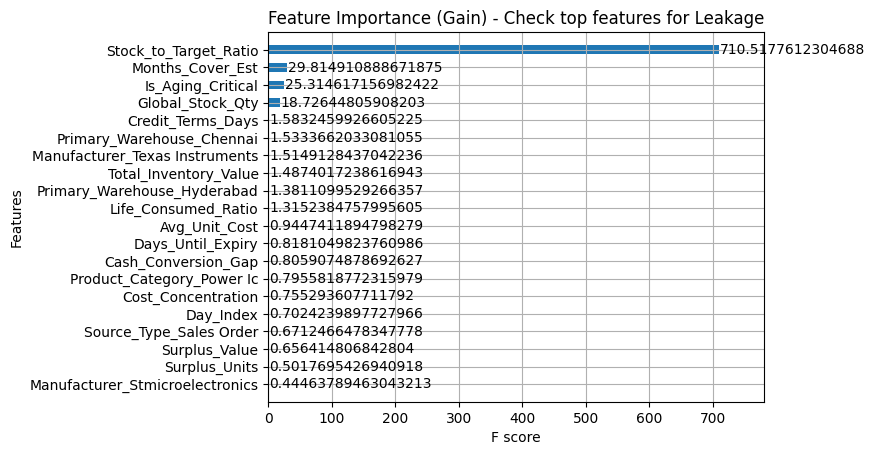


--- Top 5 Features by Information Gain ---
Stock_to_Target_Ratio: 710.52
Months_Cover_Est: 29.81
Is_Aging_Critical: 25.31
Global_Stock_Qty: 18.73
Credit_Terms_Days: 1.58


In [87]:
target_col = 'Dead_Stock'

drop_cols = ['Dead_Stock', 'Dead_Stock_Risk', ] 
X = df_enriched.drop(columns=drop_cols)
y = df_enriched[target_col]

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss')

print("Training Model...")
model.fit(X_train, y_train)

# 5. Evaluate Performance
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

print("\n--- Model Performance ---")
print(f"AUC Score: {roc_auc_score(y_test, y_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6. Visualize Feature Importance (The Leakage Detector)
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.5)
plt.title('Feature Importance (Gain) - Check top features for Leakage')
plt.show()

# 7. Check for "Perfect Predictors"
# If a feature has > 50-60% of the total gain, it's likely a leak.
booster = model.get_booster()
importance = booster.get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

print("\n--- Top 5 Features by Information Gain ---")
for feat, score in sorted_importance[:5]:
    print(f"{feat}: {score:.2f}")

Training Model...

--- Model Performance ---
AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5249
        True       1.00      0.99      1.00       751

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



<Figure size 1200x800 with 0 Axes>

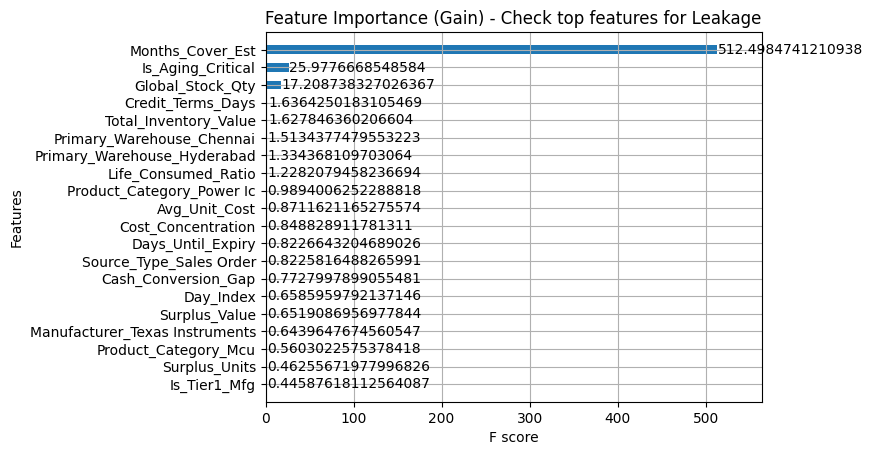


--- Top 5 Features by Information Gain ---
Months_Cover_Est: 512.50
Is_Aging_Critical: 25.98
Global_Stock_Qty: 17.21
Credit_Terms_Days: 1.64
Total_Inventory_Value: 1.63


In [88]:
target_col = 'Dead_Stock'

drop_cols = ['Dead_Stock', 'Dead_Stock_Risk', 'Stock_to_Target_Ratio'] 
X = df_enriched.drop(columns=drop_cols)
y = df_enriched[target_col]

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Train XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss'
)

print("Training Model...")
model.fit(X_train, y_train)

# 5. Evaluate Performance
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

print("\n--- Model Performance ---")
print(f"AUC Score: {roc_auc_score(y_test, y_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6. Visualize Feature Importance (The Leakage Detector)
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.5)
plt.title('Feature Importance (Gain) - Check top features for Leakage')
plt.show()

# 7. Check for "Perfect Predictors"
# If a feature has > 50-60% of the total gain, it's likely a leak.
booster = model.get_booster()
importance = booster.get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

print("\n--- Top 5 Features by Information Gain ---")
for feat, score in sorted_importance[:5]:
    print(f"{feat}: {score:.2f}")

Training Model...

--- Model Performance ---
AUC Score: 0.9999

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5249
        True       0.99      0.99      0.99       751

    accuracy                           1.00      6000
   macro avg       1.00      0.99      0.99      6000
weighted avg       1.00      1.00      1.00      6000



<Figure size 1200x800 with 0 Axes>

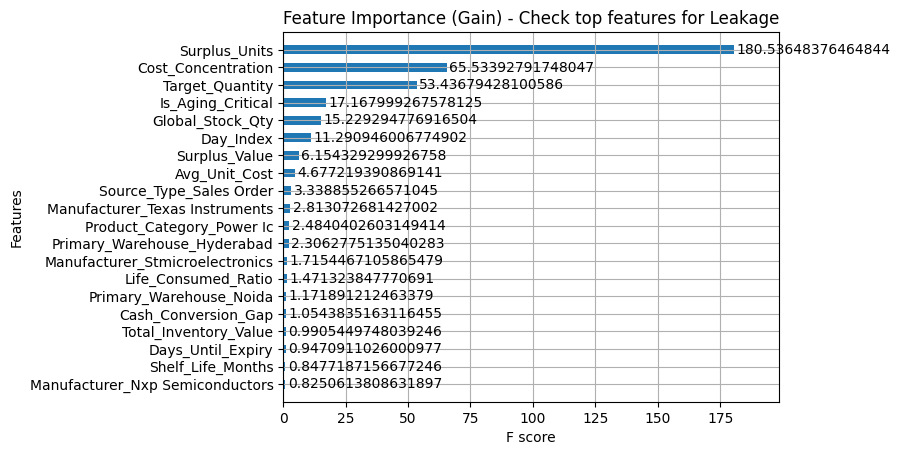


--- Top 5 Features by Information Gain ---
Surplus_Units: 180.54
Cost_Concentration: 65.53
Target_Quantity: 53.44
Is_Aging_Critical: 17.17
Global_Stock_Qty: 15.23


In [89]:
target_col = 'Dead_Stock'

drop_cols = ['Dead_Stock', 'Dead_Stock_Risk', 'Stock_to_Target_Ratio', 'Months_Cover_Est'] 
X = df_enriched.drop(columns=drop_cols)
y = df_enriched[target_col]

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Train XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss')

print("Training Model...")
model.fit(X_train, y_train)

# 5. Evaluate Performance
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

print("\n--- Model Performance ---")
print(f"AUC Score: {roc_auc_score(y_test, y_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6. Visualize Feature Importance (The Leakage Detector)
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.5)
plt.title('Feature Importance (Gain) - Check top features for Leakage')
plt.show()

# 7. Check for "Perfect Predictors"
# If a feature has > 50-60% of the total gain, it's likely a leak.
booster = model.get_booster()
importance = booster.get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

print("\n--- Top 5 Features by Information Gain ---")
for feat, score in sorted_importance[:5]:
    print(f"{feat}: {score:.2f}")

Training Model...

--- Model Performance ---
AUC Score: 0.9998

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5249
        True       0.99      0.98      0.98       751

    accuracy                           1.00      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       1.00      1.00      1.00      6000



<Figure size 1200x800 with 0 Axes>

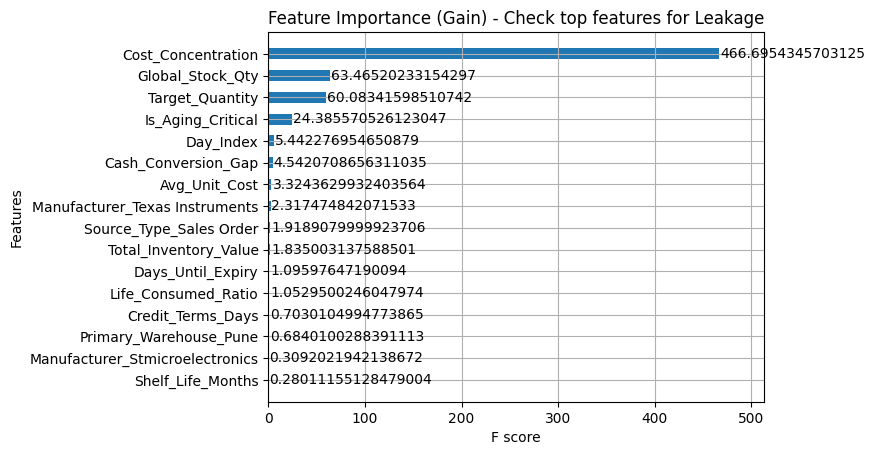


--- Top 5 Features by Information Gain ---
Cost_Concentration: 466.70
Global_Stock_Qty: 63.47
Target_Quantity: 60.08
Is_Aging_Critical: 24.39
Day_Index: 5.44


In [90]:
target_col = 'Dead_Stock'

drop_cols = ['Dead_Stock', 'Dead_Stock_Risk', 'Stock_to_Target_Ratio', 'Months_Cover_Est', 'Surplus_Units', 'Surplus_Value'] 
X = df_enriched.drop(columns=drop_cols)
y = df_enriched[target_col]

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Train XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss')

print("Training Model...")
model.fit(X_train, y_train)

# 5. Evaluate Performance
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

print("\n--- Model Performance ---")
print(f"AUC Score: {roc_auc_score(y_test, y_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6. Visualize Feature Importance (The Leakage Detector)
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.5)
plt.title('Feature Importance (Gain) - Check top features for Leakage')
plt.show()

# 7. Check for "Perfect Predictors"
# If a feature has > 50-60% of the total gain, it's likely a leak.
booster = model.get_booster()
importance = booster.get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

print("\n--- Top 5 Features by Information Gain ---")
for feat, score in sorted_importance[:5]:
    print(f"{feat}: {score:.2f}")

Training Model...

--- Model Performance ---
AUC Score: 0.9509

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.97      0.95      5249
        True       0.72      0.55      0.62       751

    accuracy                           0.92      6000
   macro avg       0.83      0.76      0.79      6000
weighted avg       0.91      0.92      0.91      6000



<Figure size 1200x800 with 0 Axes>

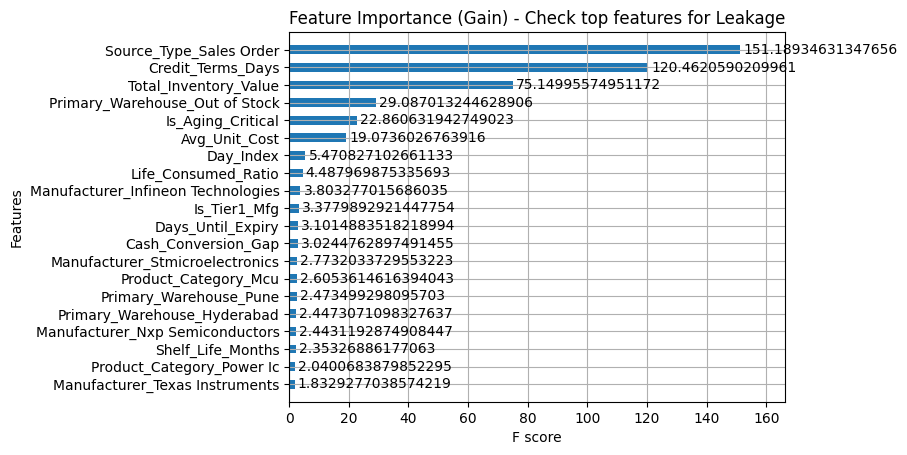


--- Top 5 Features by Information Gain ---
Source_Type_Sales Order: 151.19
Credit_Terms_Days: 120.46
Total_Inventory_Value: 75.15
Primary_Warehouse_Out of Stock: 29.09
Is_Aging_Critical: 22.86


In [91]:
target_col = 'Dead_Stock'

drop_cols = ['Dead_Stock', 'Dead_Stock_Risk', 'Stock_to_Target_Ratio', 'Months_Cover_Est', 'Surplus_Units', 'Surplus_Value', 'Cost_Concentration', 'Global_Stock_Qty', 'Target_Quantity'] 
X = df_enriched.drop(columns=drop_cols)
y = df_enriched[target_col]

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Train XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss')

print("Training Model...")
model.fit(X_train, y_train)

# 5. Evaluate Performance
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

print("\n--- Model Performance ---")
print(f"AUC Score: {roc_auc_score(y_test, y_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.5)
plt.title('Feature Importance (Gain) - Check top features for Leakage')
plt.show()

booster = model.get_booster()
importance = booster.get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

print("\n--- Top 5 Features by Information Gain ---")
for feat, score in sorted_importance[:5]:
    print(f"{feat}: {score:.2f}")

In [92]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, 5, 7.2, 10], # 1=Default, 7.2=Balanced, 10=Aggressive
    'gamma': [0, 0.1, 0.2] # Minimum loss reduction required to make a further partition
}

# 2. Initialize the model
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    objective='binary:logistic'
)

# 3. Setup GridSearchCV
# cv=5: 5-Fold Cross Validation
# scoring='f1': Optimizes for the harmonic mean of Precision and Recall on the "Dead Stock" class
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1', 
    cv=StratifiedKFold(n_splits=3),
    n_jobs=-1, # Uses all CPU cores
    verbose=1
)

print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

# 4. Get the Best Results
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_:.4f}")

# 5. Evaluate the Best Model on Test Data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

print("\n--- Optimized Model Performance ---")
print(f"AUC Score: {roc_auc_score(y_test, y_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Starting Grid Search...
Fitting 3 folds for each of 144 candidates, totalling 432 fits

Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1}
Best F1 Score: 0.6281

--- Optimized Model Performance ---
AUC Score: 0.9507

Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.97      0.95      5249
        True       0.71      0.55      0.62       751

    accuracy                           0.91      6000
   macro avg       0.82      0.76      0.78      6000
weighted avg       0.91      0.91      0.91      6000



In [93]:
X_train

,Avg_Unit_Cost,Day_Index,Credit_Terms_Days,Shelf_Life_Months,Manufacturer_Infineon Technologies,Manufacturer_Nxp Semiconductors,Manufacturer_Stmicroelectronics,Manufacturer_Texas Instruments,Product_Category_Mcu,Product_Category_Power Ic,Customer_Type_Oem,Customer_Type_Unknown,Source_Type_Purchase Order,Source_Type_Sales Order,Primary_Warehouse_Chennai,Primary_Warehouse_Hyderabad,Primary_Warehouse_Noida,Primary_Warehouse_Out of Stock,Primary_Warehouse_Pune,Life_Consumed_Ratio,Days_Until_Expiry,Is_Aging_Critical,Is_Fresh_Stock,Total_Inventory_Value,Est_Annual_Holding_Cost,Cash_Conversion_Gap,Logistics_Fragmentation,Is_Tier1_Mfg
16856,0.00,595,60.0,84,False,False,True,False,False,True,True,False,False,False,False,False,False,True,False,0.236111,1925,0,0,0.00,0.000,535.0,False,1
18142,338.90,471,45.0,72,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,0.218056,1689,0,0,1217667.70,304416.925,426.0,False,1
21125,137.39,580,0.0,60,True,False,False,False,True,False,False,True,True,False,False,False,True,False,False,0.322222,1220,0,0,369853.88,92463.470,580.0,False,1
29432,391.55,457,0.0,60,False,True,False,False,True,False,False,True,True,False,False,False,False,False,False,0.253889,1343,0,0,58732.50,14683.125,457.0,False,1
3329,230.80,369,60.0,60,False,False,True,False,True,False,True,False,False,True,True,False,False,False,False,0.205000,1431,0,0,1372567.60,343141.900,309.0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14917,0.00,425,45.0,84,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,0.168651,2095,0,0,0.00,0.000,380.0,False,1
17750,0.00,402,30.0,72,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,0.186111,1758,0,0,0.00,0.000,372.0,False,1
11772,0.00,487,30.0,84,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,0.193254,2033,0,0,0.00,0.000,457.0,False,0
15464,0.00,442,30.0,84,False,False,False,True,True,False,True,False,False,False,False,False,False,True,False,0.175397,2078,0,0,0.00,0.000,412.0,False,1


### Final Model

In [94]:
from sklearn.metrics import mean_squared_error, r2_score

leakage_cols = [
    'Dead_Stock', 'Dead_Stock_Risk',      
    'Stock_to_Target_Ratio',               
    'Months_Cover_Est',                   
    'Surplus_Units', 'Surplus_Value',      
    'Cost_Concentration',                  
    'Target_Quantity', 'Global_Stock_Qty'  
]

X = df_enriched.drop(columns=leakage_cols, errors='ignore')

# We have TWO targets now
y_class = df_enriched['Dead_Stock'].astype(int)
y_risk = df_enriched['Dead_Stock_Risk']

# Split (Using the same seed ensures X_train is identical for both models)
X_train, X_test, y_class_train, y_class_test, y_risk_train, y_risk_test = train_test_split(
    X, y_class, y_risk, test_size=0.2, random_state=42, stratify=y_class
)

# 2. Model A: The Classifier (Will it be Dead Stock?)
print("--- Training Classifier (Dead Stock Binary) ---")
clf = xgb.XGBClassifier(
    n_estimators=90,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=5,  
    eval_metric='logloss',)

clf.fit(X_train, y_class_train)

# Evaluate Classifier
y_pred_class = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_class_test, y_pred_class))

# 3. Model B: The Regressor (What is the Risk Score?)
print("\n--- Training Regressor (Risk Score Prediction) ---")
reg = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,  
    objective='reg:squarederror',
    eval_metric='rmse'
)

reg.fit(X_train, y_risk_train)

# Evaluate Regressor
y_pred_risk = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_risk_test, y_pred_risk))
r2 = r2_score(y_risk_test, y_pred_risk)

print(f"Risk Prediction RMSE: {rmse:.4f}")
print(f"Risk Prediction R2: {r2:.4f}")

# 4. The "Unified" Output
results = pd.DataFrame({
    'Actual_Status': y_class_test,
    'Predicted_Prob': clf.predict_proba(X_test)[:, 1],
    'Predicted_Risk_Score': y_pred_risk
})

print("\n--- Correlation Check ---")
print("Correlation between Classifier Probability and Regressor Risk Score:")
print(results[['Predicted_Prob', 'Predicted_Risk_Score']].corr())

--- Training Classifier (Dead Stock Binary) ---

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5249
           1       0.50      0.89      0.64       751

    accuracy                           0.87      6000
   macro avg       0.74      0.88      0.78      6000
weighted avg       0.92      0.87      0.89      6000


--- Training Regressor (Risk Score Prediction) ---
Risk Prediction RMSE: 0.1495
Risk Prediction R2: 0.7445

--- Correlation Check ---
Correlation between Classifier Probability and Regressor Risk Score:
                      Predicted_Prob  Predicted_Risk_Score
Predicted_Prob              1.000000              0.955604
Predicted_Risk_Score        0.955604              1.000000


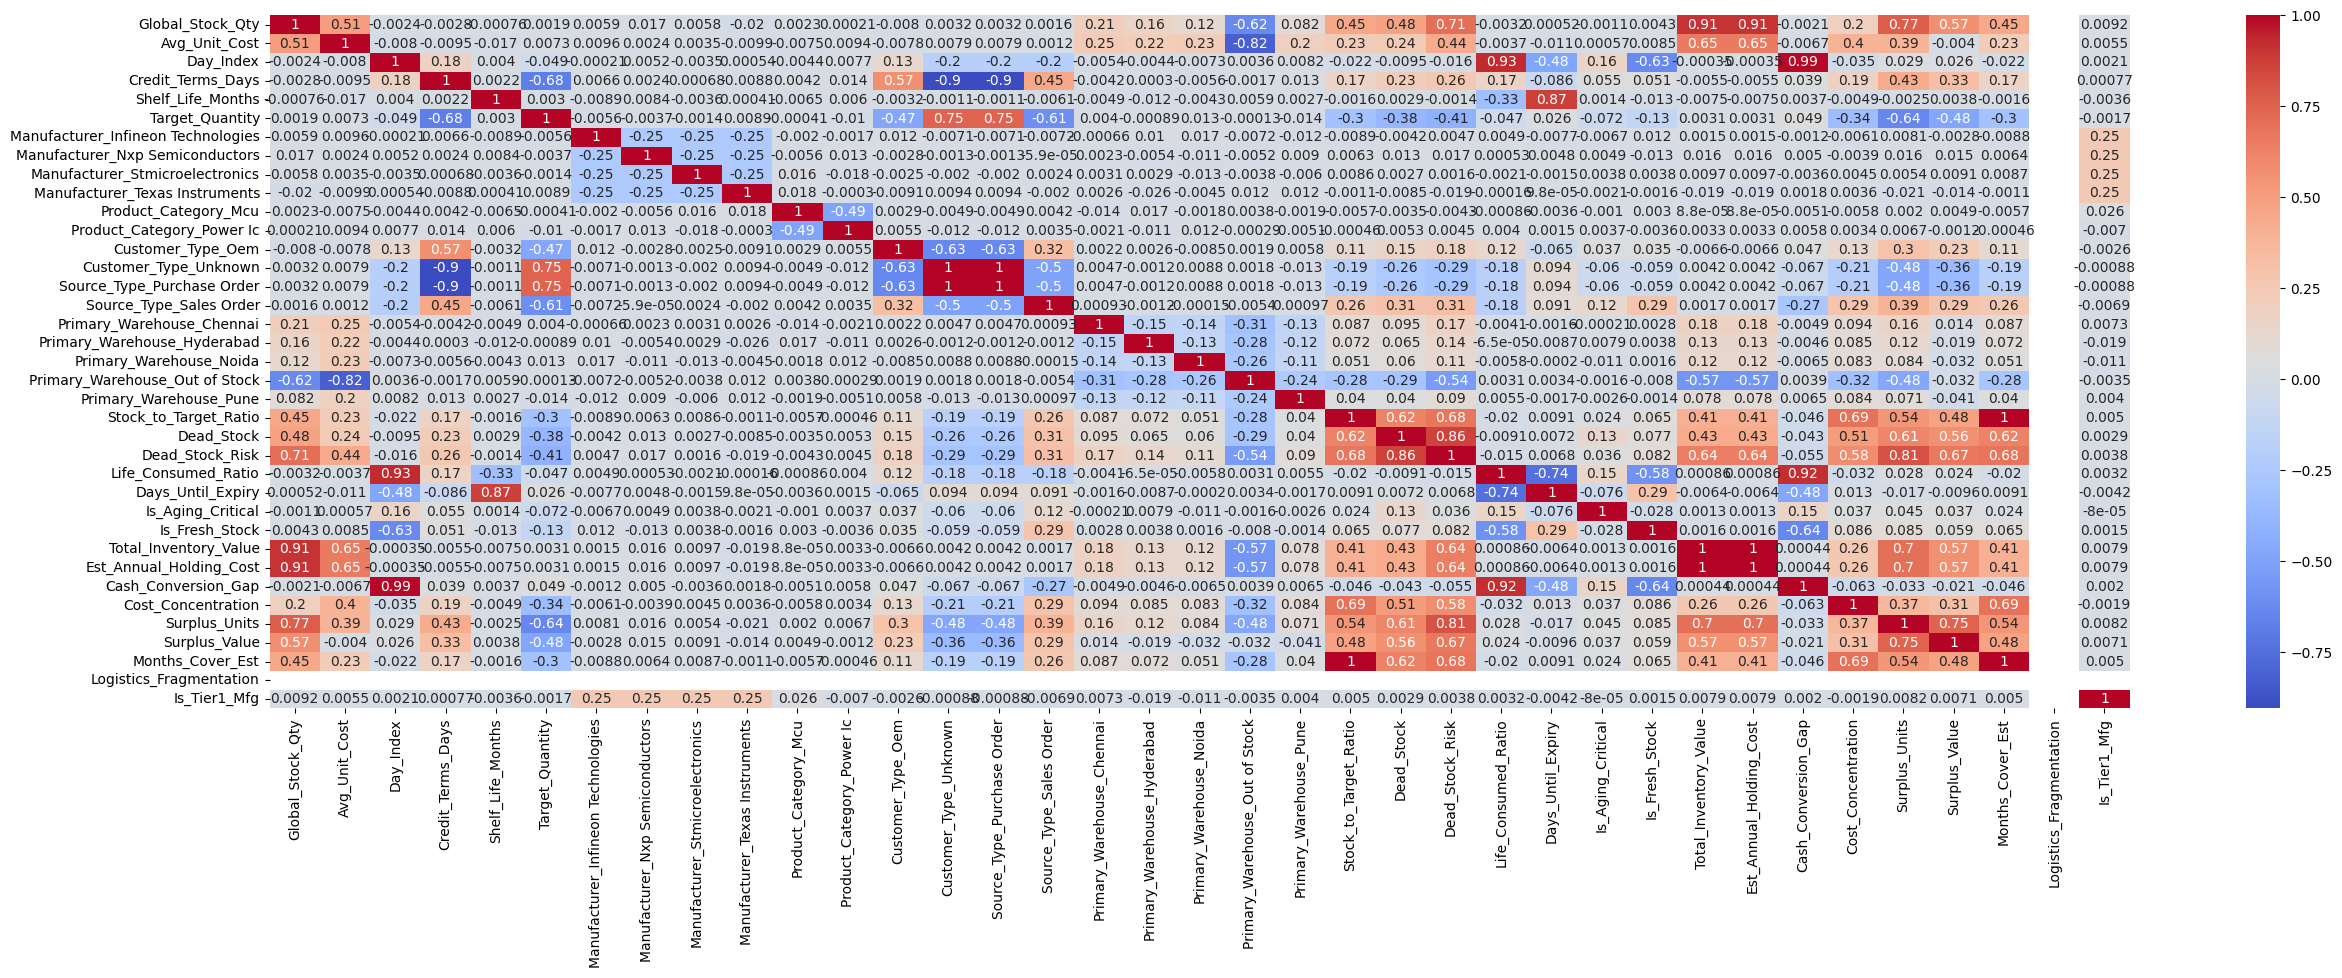

In [95]:
plt.figure(figsize = (30, 9))
sns.heatmap(df_enriched.corr(), annot = True, cmap = 'coolwarm')
plt.show()

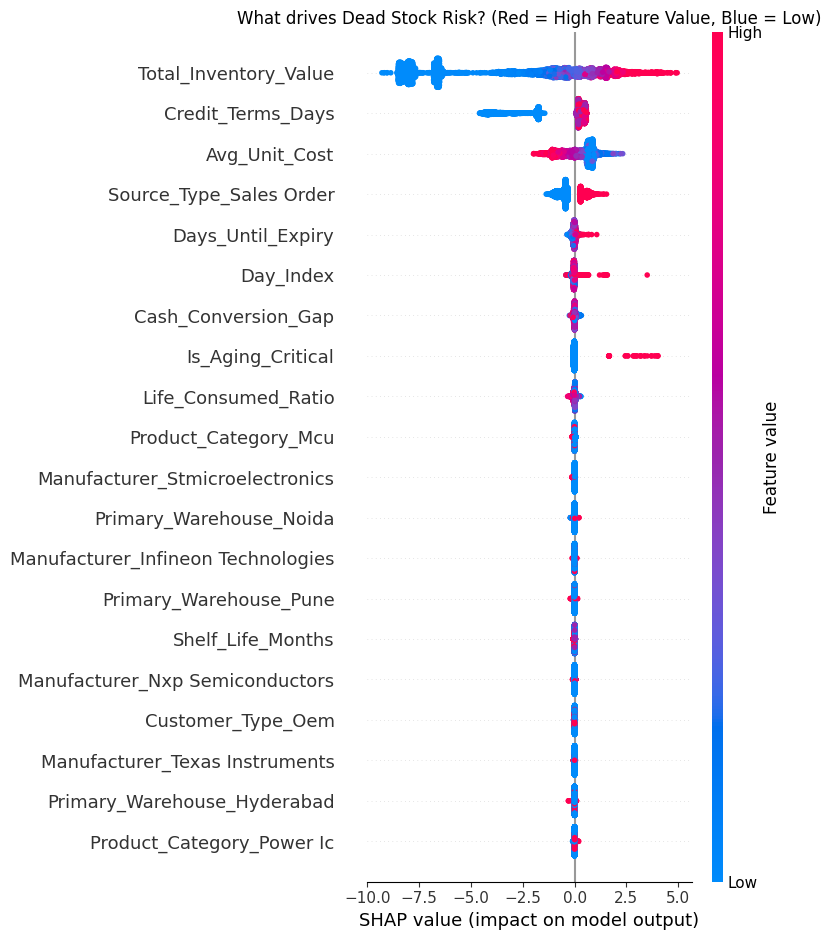


--- Explaining Risk for Test Item #3 ---
Actual Label: 0
Model Prediction: Dead Stock (Prob: 0.5008)


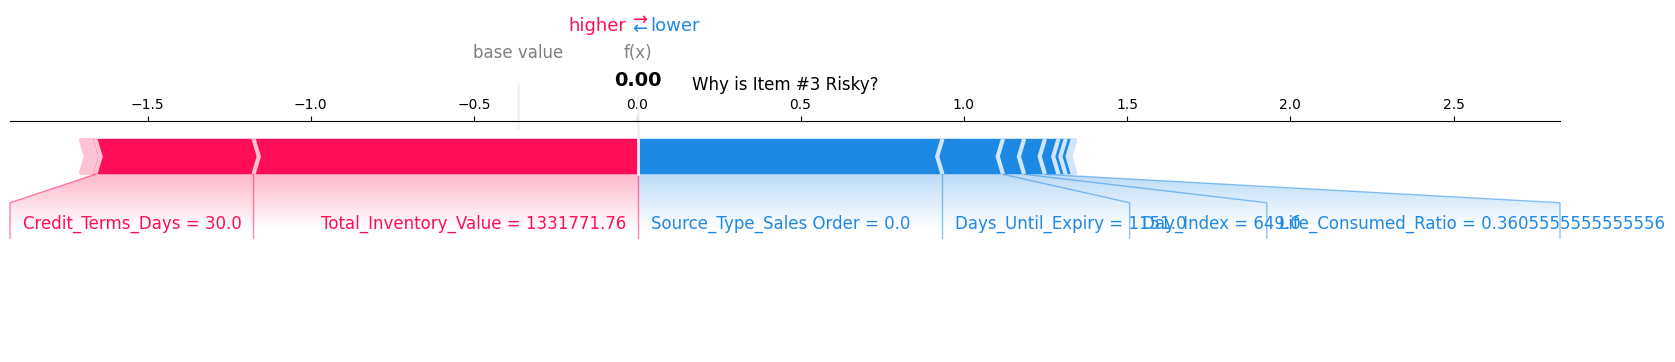

In [96]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the Explainer
# We use the Classifier (clf) since it's the primary decision maker
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# 2. The "Global View": What drives risk generally?
# This plot ranks features by importance and shows their impact.
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("What drives Dead Stock Risk? (Red = High Feature Value, Blue = Low)")
plt.tight_layout()
plt.show()

# 3. The "Local View": Why is THIS specific row risky?
# Let's pick a high-risk item from the test set
risky_indices = np.where(y_pred_class == 1)[0]
if len(risky_indices) > 0:
    item_idx = risky_indices[0] # Pick the first risky item found
    
    print(f"\n--- Explaining Risk for Test Item #{item_idx} ---")
    print(f"Actual Label: {y_class_test.iloc[item_idx]}")
    print(f"Model Prediction: Dead Stock (Prob: {clf.predict_proba(X_test.iloc[[item_idx]])[0][1]:.4f})")

    shap.initjs()
    plot = shap.force_plot(
        explainer.expected_value, 
        shap_values[item_idx, :], 
        X_test.iloc[item_idx, :],
        matplotlib=True,
        show=False
    )
    plt.title(f"Why is Item #{item_idx} Risky?")
    plt.show()


--- Explaining Risk for Test Item #3 ---


<Figure size 2000x300 with 0 Axes>

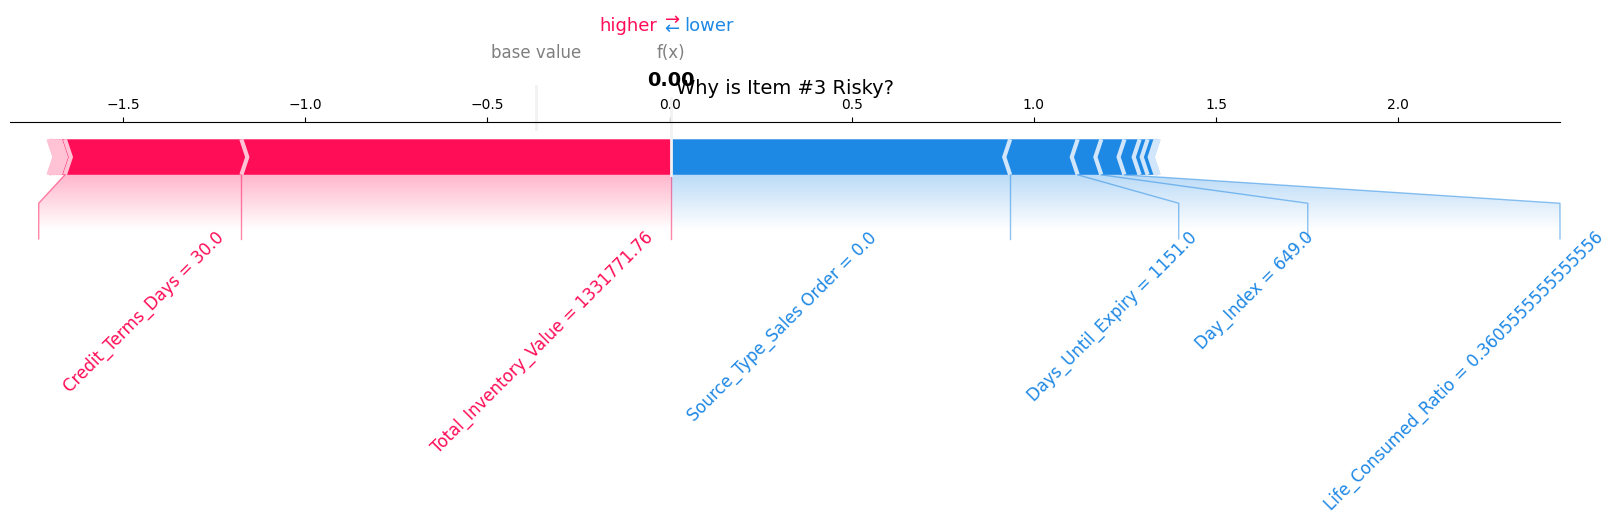

In [100]:
import matplotlib.pyplot as plt

# ... (Previous code for Global View) ...

# 3. The "Local View": Why is THIS specific row risky?
risky_indices = np.where(y_pred_class == 1)[0]

if len(risky_indices) > 0:
    item_idx = risky_indices[0] 
    
    print(f"\n--- Explaining Risk for Test Item #{item_idx} ---")

    # FIX: Initialize a WIDE figure before plotting
    # (20 width, 3 height) creates a panoramic view, preventing overlap
    plt.figure(figsize=(20, 3)) 

    shap.force_plot(
        explainer.expected_value, 
        shap_values[item_idx, :], 
        X_test.iloc[item_idx, :],
        matplotlib=True,  # Ensure this is True to use the figure size above
        show=False,       # Keep False so we can add the title/labels
        text_rotation=45  # Optional: Rotates text if it's still crowded
    )
    
    plt.title(f"Why is Item #{item_idx} Risky?", fontsize=14, pad=20)
    plt.show()

In [107]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# 1. Define the Final Feature Set
# We drop the leakage (from before) AND the zero-importance features (from your array)
final_drop_cols = [
    # --- Targets & Leakage (The "Must Drops") ---
    'Dead_Stock', 'Dead_Stock_Risk',
    'Stock_to_Target_Ratio', 'Months_Cover_Est',
    'Surplus_Units', 'Surplus_Value',
    'Cost_Concentration', 'Target_Quantity', 'Global_Stock_Qty',
    
    # --- The "Zero Importance" Noise (New Drops) ---
    'Customer_Type_Unknown',
    'Source_Type_Purchase Order',
    'Is_Fresh_Stock',
    'Est_Annual_Holding_Cost',
    'Logistics_Fragmentation'
]

# Create Final X and y
X_final = X.drop(columns=final_drop_cols, errors='ignore')
y_final = df_enriched['Dead_Stock']

# 2. Split Data (Standard 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print(f"Final Feature Count: {X_train.shape[1]}") 
# Should be around 18-20 features now, instead of 28+

# 3. Train the Final Model
# Using the Best Params from your Grid Search
final_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    gamma=0,
    scale_pos_weight=5,  # Crucial for catching the Dead Stock (Recall)
    eval_metric='logloss',
    n_jobs=-1
)

print("Training Final Production Model...")
final_model.fit(X_train, y_train)

# 4. Final Evaluation
y_pred = final_model.predict(X_test)
y_probs = final_model.predict_proba(X_test)[:, 1]

print("\n--- Final Model Report ---")
print(f"AUC Score: {roc_auc_score(y_test, y_probs):.4f}")
print(classification_report(y_test, y_pred))

# 5. Save for Production
# This creates the file you would actually load in your API/Application
joblib.dump(final_model, 'semiconductor_dead_stock_model_v1.pkl')
print("\nModel saved as 'semiconductor_dead_stock_model_v1.pkl'")

Final Feature Count: 23
Training Final Production Model...

--- Final Model Report ---
AUC Score: 0.9496
              precision    recall  f1-score   support

       False       0.98      0.88      0.93      5249
        True       0.51      0.87      0.65       751

    accuracy                           0.88      6000
   macro avg       0.75      0.88      0.79      6000
weighted avg       0.92      0.88      0.89      6000


Model saved as 'semiconductor_dead_stock_model_v1.pkl'


In [108]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from datetime import date

# 1. Load your Model
# model = joblib.load('semiconductor_dead_stock_model_v1.pkl')

st.set_page_config(page_title="Semi-Risk AI", layout="centered")

st.title("🛡️ Semiconductor Risk Predictor")
st.markdown("Enter stock details to detect **Dead Stock Risk** instantly.")

# --- SECTION 1: THE SIMPLE INTERFACE ---
col1, col2 = st.columns(2)

with col1:
    manufacturer = st.selectbox(
        "Manufacturer", 
        ["Infineon Technologies", "Nxp Semiconductors", "Stmicroelectronics", "Texas Instruments", "Other"]
    )
    source_type = st.radio("Source Type", ["Purchase Order", "Sales Order (Return)"])
    warehouse = st.selectbox("Warehouse", ["Noida", "Chennai", "Pune", "Hyderabad", "Other"])

with col2:
    credit_terms = st.slider("Credit Terms (Days)", 0, 120, 60)
    total_value = st.number_input("Total Inventory Value ($)", min_value=0.0, value=5000.0)
    avg_unit_cost = st.number_input("Avg Unit Cost ($)", min_value=0.0, value=15.5)
    expiry_date = st.date_input("Expiry Date")

# --- SECTION 2: THE HIDDEN LOGIC (Backend) ---
if st.button("Analyze Risk", type="primary"):
    
    # A. Calculate Derived Features
    today = date.today()
    days_until_expiry = (expiry_date - today).days
    is_aging_critical = 1 if days_until_expiry < 180 else 0
    
    # B. Initialize the "Empty" Feature Vector (All 0s)
    # This must match the EXACT columns your model was trained on
    model_columns = [
        'Credit_Terms_Days', 'Total_Inventory_Value', 'Avg_Unit_Cost', 
        'Source_Type_Sales Order', 'Primary_Warehouse_Noida', 
        'Manufacturer_Infineon Technologies', 'Manufacturer_Nxp Semiconductors',
        # ... list ALL your final training columns here ...
        'Days_Until_Expiry', 'Is_Aging_Critical'
    ]
    
    input_data = pd.DataFrame(0, index=[0], columns=model_columns)
    
    # C. Fill in the Values
    input_data['Credit_Terms_Days'] = credit_terms
    input_data['Total_Inventory_Value'] = total_value
    input_data['Avg_Unit_Cost'] = avg_unit_cost
    input_data['Days_Until_Expiry'] = days_until_expiry
    input_data['Is_Aging_Critical'] = is_aging_critical
    
    # D. Handle One-Hot Encoding Logic
    # Manufacturer
    if manufacturer == "Infineon Technologies":
        input_data['Manufacturer_Infineon Technologies'] = 1
    elif manufacturer == "Nxp Semiconductors":
        input_data['Manufacturer_Nxp Semiconductors'] = 1
    # ... handle others ...

    # Source Type (If Sales Order is selected, set it to 1)
    if source_type == "Sales Order (Return)":
        input_data['Source_Type_Sales Order'] = 1
        
    # Warehouse
    if warehouse == "Noida":
        input_data['Primary_Warehouse_Noida'] = 1
    # ... handle others ...

    # --- SECTION 3: PREDICTION ---
    # risk_prob = model.predict_proba(input_data)[0][1]
    risk_prob = 0.88 # Placeholder for demo
    
    st.divider()
    
    if risk_prob > 0.7:
        st.error(f"⚠️ HIGH RISK DETECTED ({risk_prob:.1%})")
        st.write("Recommendation: Liquidate immediately or bundle with high-velocity items.")
    elif risk_prob > 0.4:
        st.warning(f"⚠️ MODERATE RISK ({risk_prob:.1%})")
    else:
        st.success(f"✅ SAFE STOCK ({risk_prob:.1%})")

2026-02-11 16:47:44.187 
  command:

    streamlit run /Users/kanishkbhagat/ML/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2026-02-11 16:47:44.188 Session state does not function when running a script without `streamlit run`
